# Forecasting Code for Mutivariate Time Series Data
## Getting Started
In this notebook, we will create an AI and time serie driven forecasting engine based on a set of 5 AI models and 5 time series models and employ several algorithms to perform feature engennering and selection on a multivaraite time series dataset. We are trying to find the best drivers of the HK flat price using various macro economics data.The dataset we are using is the 'HK macroeconomics data' from Kaggle. It is a daily dataset starting from 2nd January 2003 and goes on till 26th November 2019. The target variable is 'Private Domestic (Price Index)' and there 12 features which can help us forecast HK flat price.


We will first do exploratory data analysis on the data and then move on to data cleaning where we do the following:

1. Check if any dates are missing and add the missing dates
2. Use linear interpolation to fill the nulls (we will also provide the code for forward and backward fill
3. Perform outlier detection
4. Perform outlier treatment
5. Check time series components, ACF and PACF plots of target variable

Once the data has been cleaned up, we will create the following additional features:

1. 3 lags for each feature
2. Daily change for each feature
3. A flag for holidays
4. Calculate First hand sales price and drop the sales amount variable

The next step is to perform featue selection using the following techniques:

1. Select the top n features based on feature importance from random forest
2. Select the top n features based on absolute correlation with target variable
3. Select the features identified by Lasso regression
4. Select features by recursively considering smaller and smaller sets of features
5. Select the top n features based on absolute value of beta coefficients of features

The final features are the ones selected in at least 3 out of 5 models.

After feature selection, we train a set of 10 models (and perform hyper parameter tuning wherever required):

1. SARIMA (Univariate Time Series)
2. Holt Winters (Univariate Time Series)
3. SARIMAX(Multi-variate Time Series)
4. VAR(Multi-variate Time Series)
5. VECM(Multi-variate Time Series)
6. LSTM (Univariate Time Series)
7. Random Forest (Multi-variate AI)
8. XG Boost (Multi-variate AI)
9. Linear Regression (Multi-variate AI)
10. SVR (Multi-variate AI)

We make predictions for the next year using all the models and then take their average as the final predictions.

The first step is to understand the data using exploratory data analysis (EDA)as it helps us create the logical approach for solving the business problem. It also allows us to identify the issues like outliers existing in our dataset.

**How well we clean and understand the data has a tremendous impact on the quality of the results.**


Things get slightly more complicated when we deal with datasets having hidden properties like time series datasets. Time series datasets is a special type of data which is ordered chronologically and needs special attention for handling it’s intrinsic elements like trend and seasonality.

## Index
* Understanding time series data — The Theory
* EDA (inspection, data profiling, visualizations)
* Data Cleaning (missing data, outlier detection and treatment)

Decomposition techniques help us extract trend, seasonality and error/irregular components of a time series dataset.

### Stationarity
In the most intuitive sense, a stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times.

Why is this property important? Stationary processes are easier to model as the way they change is predictable and stable. For most models involving time series, we will find ourselves determining if the data was generated by a stationary process, and if not, then we possibly need to transform it so it has the properties generated by such a process.

### ACF and PACF
Autocorrelation (ACF) and partial autocorrelation (PACF) plots are heavily used to determine stationarity and time series model parameters.These plots graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps.


For ACF plots, we calculate the correlation for time series observations with observations with previous time steps, called lags. The PACF plot is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed. Such time plots for a stationary process will have start having statistically insignificant values within the first few lags.

# EDA (inspection, data profiling, visualizations)

### Import all the libraries

In [1]:
# Import Necessary Libraries

#!pip install pyod

import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
from scipy.stats.mstats import zscore
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pandas import Series
from matplotlib import pyplot

import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import *


import itertools
import math
import random
import xgboost as xgb
import tensorflow
import keras
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

# !pip install --trusted-host=pypi.org --trusted-host=files.pythonhosted.org --user pmdarima

In [2]:
# Input the dataset
df1 = pd.read_excel('Housing market data.xlsx',
              sheet_name='Upsampled')

df1.head(5)

,Date,Private Domestic (Price Index),First hand sales quantity,First hand sales amount,Total completions,Total stock,Total take up,Total vacancy,Unemployment rate (seasonally adjusted) (%),CPI,HIBOR (1-month),M3 (HK$ million),HSI - close,HSI - volume
0,2003-01-02,64.559769,1854.689208,5.846897e+09,33983.762413,1.092844e+06,19914.083323,74177.818318,7.301525,73.721486,1.44420,3.562189e+06,9365.519531,126907400.0
1,2003-01-03,64.506848,1892.762372,5.927523e+09,33932.818955,1.092244e+06,19900.006814,74155.621001,7.299043,73.717079,1.41741,3.562586e+06,9583.849609,291454400.0
2,2003-01-06,64.453848,1931.338866,5.998876e+09,33882.041253,1.091646e+06,19886.125236,74133.429251,7.296561,73.712684,1.40402,3.563044e+06,9665.959961,234912800.0
3,2003-01-07,64.400768,1970.418692,6.060958e+09,33831.429307,1.091050e+06,19872.438591,74111.243068,7.294081,73.708301,1.39063,3.563562e+06,9652.400391,267021800.0
4,2003-01-08,64.347610,2010.001848,6.113768e+09,33780.983117,1.090457e+06,19858.946877,74089.062450,7.291601,73.703930,1.39732,3.564141e+06,9688.209961,202439200.0


In [3]:
df1.shape

(4233, 14)

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4233 entries, 0 to 4232
Data columns (total 14 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   Date                                         4233 non-null   datetime64[ns]
 1   Private Domestic (Price Index)               4233 non-null   float64       
 2   First hand sales quantity                    4233 non-null   float64       
 3   First hand sales amount                      4233 non-null   float64       
 4   Total completions                            4233 non-null   float64       
 5   Total stock                                  4233 non-null   float64       
 6   Total take up                                4233 non-null   float64       
 7   Total vacancy                                4233 non-null   float64       
 8   Unemployment rate (seasonally adjusted) (%)  4233 non-null   float64       
 9

In [5]:
df1.isna().sum()

Date                                           0
Private Domestic (Price Index)                 0
First hand sales quantity                      0
First hand sales amount                        0
Total completions                              0
Total stock                                    0
Total take up                                  0
Total vacancy                                  0
Unemployment rate (seasonally adjusted) (%)    0
CPI                                            0
HIBOR (1-month)                                0
M3 (HK$ million)                               0
HSI - close                                    0
HSI - volume                                   0
dtype: int64

In [6]:
# Understanding the numeric fields
df1.describe()

,Private Domestic (Price Index),First hand sales quantity,First hand sales amount,Total completions,Total stock,Total take up,Total vacancy,Unemployment rate (seasonally adjusted) (%),CPI,HIBOR (1-month),M3 (HK$ million),HSI - close,HSI - volume
count,4233.000000,4233.000000,4.233000e+03,4233.000000,4.233000e+03,4233.000000,4233.000000,4233.000000,4233.000000,4233.000000,4.233000e+03,4233.000000,4.233000e+03
mean,197.064993,1406.732017,1.145308e+10,15387.011646,1.106643e+06,14036.055785,52835.021903,4.202867,88.188533,1.180317,8.375635e+06,20781.490429,1.492191e+09
std,104.268475,758.310792,6.934301e+09,6413.960753,5.073772e+04,6483.743342,9013.878325,1.273481,12.713668,1.415258,3.553012e+06,5303.246267,9.137858e+08
min,58.400000,-2.690601,4.424446e+05,6792.576078,1.006630e+06,-4077.411618,41975.928483,2.800000,71.700000,0.040180,3.548561e+06,8409.009766,0.000000e+00
25%,96.834930,863.244685,6.124111e+09,9942.919441,1.073121e+06,9516.701115,45758.833205,3.134502,75.520451,0.212860,5.279677e+06,17048.419922,9.293672e+08
50%,181.300974,1292.923682,1.038705e+10,13810.857627,1.106639e+06,12693.239693,49973.213330,3.649037,86.187916,0.345000,7.660015e+06,21654.160156,1.495348e+09
75%,284.135754,1845.392958,1.568220e+10,19112.456257,1.142288e+06,16988.464263,62994.641229,5.077025,100.297864,1.747140,1.147862e+07,23919.949219,1.947201e+09
max,397.100022,4151.298770,3.834408e+10,33983.762413,1.214837e+06,31536.196716,74177.818318,8.500000,111.000000,5.703570,1.470108e+07,33154.121094,9.799120e+09


* Here as you can notice mean value is more than median value of most columns which is represented by 50%(50th percentile) in index column.

* There is notably a big difference between 75th percentile and max values of certain fields like “First hand sales quantity”,”First hand sales amount”,”Total completions” etc.

* Thus observations 1 and 2 suggests that there are extreme values-Outliers in our data set. We get the same conclusion once we look at the histograms of all the numeric fields.

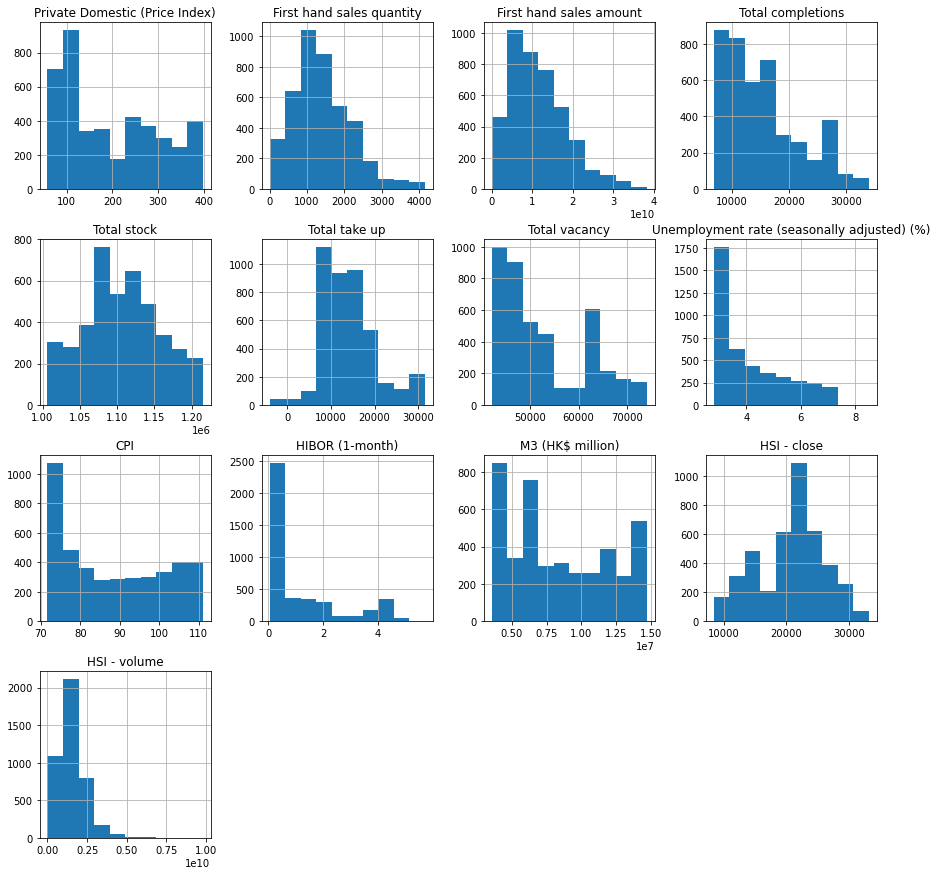

In [7]:
# Histogram of all numeric fields
df_hist = df1.drop(columns=['Date'], axis=1)
df_hist.hist(figsize=(15,15));

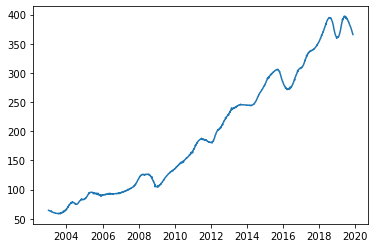

In [8]:
# Visaluise the target variable
plt.plot(df1['Date'], df1['Private Domestic (Price Index)'])

* Target variable/Dependent variable (‘Private Domestic (Price Index)’)has a rising trend
* There is a seasonal dip in most years.
* The variation in 2020 are extreme compared to overall trend
* The target variable is not stationary

### Cleaning the Data

In this section we do the following:

1. Check if any dates are missing and add the missing dates
2. Use linear interpolation to fill the nulls (we will also provide the code for forward and backward fill
3. Perform outlier detection
4. Perform outlier treatment


In [9]:
# Check if any dates are missing
daily_data = pd.DataFrame(pd.date_range(start=df1['Date'].min(),end=df1['Date'].max()))
daily_data.rename(columns={ daily_data.columns[0]: "Date" }, inplace = True)
daily_data.describe()

C:\Users\DATASC~1\AppData\Local\Temp/ipykernel_23516/3876389398.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  daily_data.describe()


,Date
count,6173
unique,6173
top,2003-01-02 00:00:00
freq,1
first,2003-01-02 00:00:00
last,2019-11-26 00:00:00


In [10]:
daily_data.head()

,Date
0,2003-01-02
1,2003-01-03
2,2003-01-04
3,2003-01-05
4,2003-01-06


There are 6173 records between "2003-01-02" and "2019-11-26" but the original data only had 4233 record. So a few dates are missing.


In [11]:
# Add the missing dates
df2 = pd.merge(df1,daily_data,on='Date',how='outer')
df2 = df2.sort_values(by=['Date'])
df2.head(10)

,Date,Private Domestic (Price Index),First hand sales quantity,First hand sales amount,Total completions,Total stock,Total take up,Total vacancy,Unemployment rate (seasonally adjusted) (%),CPI,HIBOR (1-month),M3 (HK$ million),HSI - close,HSI - volume
0,2003-01-02,64.559769,1854.689208,5.846897e+09,33983.762413,1.092844e+06,19914.083323,74177.818318,7.301525,73.721486,1.44420,3.562189e+06,9365.519531,126907400.0
1,2003-01-03,64.506848,1892.762372,5.927523e+09,33932.818955,1.092244e+06,19900.006814,74155.621001,7.299043,73.717079,1.41741,3.562586e+06,9583.849609,291454400.0
4233,2003-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4234,2003-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003-01-06,64.453848,1931.338866,5.998876e+09,33882.041253,1.091646e+06,19886.125236,74133.429251,7.296561,73.712684,1.40402,3.563044e+06,9665.959961,234912800.0
3,2003-01-07,64.400768,1970.418692,6.060958e+09,33831.429307,1.091050e+06,19872.438591,74111.243068,7.294081,73.708301,1.39063,3.563562e+06,9652.400391,267021800.0
4,2003-01-08,64.347610,2010.001848,6.113768e+09,33780.983117,1.090457e+06,19858.946877,74089.062450,7.291601,73.703930,1.39732,3.564141e+06,9688.209961,202439200.0
5,2003-01-09,64.294373,2050.088335,6.157306e+09,33730.702683,1.089865e+06,19845.650096,74066.887400,7.289122,73.699570,1.43080,3.564781e+06,9675.410156,129623200.0
6,2003-01-10,64.241057,2090.678153,6.191572e+09,33680.588005,1.089275e+06,19832.548246,74044.717915,7.286643,73.695223,1.43973,3.565481e+06,9721.500000,172862200.0
4235,2003-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df2.isna().sum()

Date                                              0
Private Domestic (Price Index)                 1940
First hand sales quantity                      1940
First hand sales amount                        1940
Total completions                              1940
Total stock                                    1940
Total take up                                  1940
Total vacancy                                  1940
Unemployment rate (seasonally adjusted) (%)    1940
CPI                                            1940
HIBOR (1-month)                                1940
M3 (HK$ million)                               1940
HSI - close                                    1940
HSI - volume                                   1940
dtype: int64

* Our raw data starts from “2003–01–02” and ends at “2019–11–26”. There are 6173 days between “2003–01–02” and “2019–11–26” but the original data only had 4233 record. So a few dates are missing.

* We create a new dataset with all the 6173 dates and join the original dataset with this new dataset. This leads to null values for all the record not available in the original dataset.

In [13]:
#Use linear interpolation to fill up nulls
df3 = df2.interpolate(method='pad', limit_direction="forward", axis=0)
#df3 = df2.interpolate(method='linear', axis=0).ffill().bfill()
df3.head(10)

,Date,Private Domestic (Price Index),First hand sales quantity,First hand sales amount,Total completions,Total stock,Total take up,Total vacancy,Unemployment rate (seasonally adjusted) (%),CPI,HIBOR (1-month),M3 (HK$ million),HSI - close,HSI - volume
0,2003-01-02,64.559769,1854.689208,5.846897e+09,33983.762413,1.092844e+06,19914.083323,74177.818318,7.301525,73.721486,1.44420,3.562189e+06,9365.519531,126907400.0
1,2003-01-03,64.506848,1892.762372,5.927523e+09,33932.818955,1.092244e+06,19900.006814,74155.621001,7.299043,73.717079,1.41741,3.562586e+06,9583.849609,291454400.0
4233,2003-01-04,64.506848,1892.762372,5.927523e+09,33932.818955,1.092244e+06,19900.006814,74155.621001,7.299043,73.717079,1.41741,3.562586e+06,9583.849609,291454400.0
4234,2003-01-05,64.506848,1892.762372,5.927523e+09,33932.818955,1.092244e+06,19900.006814,74155.621001,7.299043,73.717079,1.41741,3.562586e+06,9583.849609,291454400.0
2,2003-01-06,64.453848,1931.338866,5.998876e+09,33882.041253,1.091646e+06,19886.125236,74133.429251,7.296561,73.712684,1.40402,3.563044e+06,9665.959961,234912800.0
3,2003-01-07,64.400768,1970.418692,6.060958e+09,33831.429307,1.091050e+06,19872.438591,74111.243068,7.294081,73.708301,1.39063,3.563562e+06,9652.400391,267021800.0
4,2003-01-08,64.347610,2010.001848,6.113768e+09,33780.983117,1.090457e+06,19858.946877,74089.062450,7.291601,73.703930,1.39732,3.564141e+06,9688.209961,202439200.0
5,2003-01-09,64.294373,2050.088335,6.157306e+09,33730.702683,1.089865e+06,19845.650096,74066.887400,7.289122,73.699570,1.43080,3.564781e+06,9675.410156,129623200.0
6,2003-01-10,64.241057,2090.678153,6.191572e+09,33680.588005,1.089275e+06,19832.548246,74044.717915,7.286643,73.695223,1.43973,3.565481e+06,9721.500000,172862200.0
4235,2003-01-11,64.241057,2090.678153,6.191572e+09,33680.588005,1.089275e+06,19832.548246,74044.717915,7.286643,73.695223,1.43973,3.565481e+06,9721.500000,172862200.0


In [14]:
df3.tail(10)

,Date,Private Domestic (Price Index),First hand sales quantity,First hand sales amount,Total completions,Total stock,Total take up,Total vacancy,Unemployment rate (seasonally adjusted) (%),CPI,HIBOR (1-month),M3 (HK$ million),HSI - close,HSI - volume
6170,2019-11-17,368.799164,3392.293780,2.240656e+10,24057.847763,1.214143e+06,-3435.967029,68233.623896,3.250453,109.995446,2.049219,1.432244e+07,26326.660156,1.180283e+09
4226,2019-11-18,368.380599,3493.918184,2.297096e+10,24072.591819,1.214242e+06,-3526.994787,68330.433432,3.251019,110.001500,2.052133,1.431227e+07,26681.089844,1.425323e+09
4227,2019-11-19,367.959262,3597.810882,2.354962e+10,24087.341648,1.214341e+06,-3618.224940,68427.425348,3.251584,110.007549,2.055049,1.430191e+07,27093.800781,1.542579e+09
4228,2019-11-20,367.535153,3703.971873,2.414254e+10,24102.097251,1.214440e+06,-3709.657487,68524.599646,3.252151,110.013591,2.057968,1.429137e+07,26889.609375,1.333244e+09
4229,2019-11-21,367.108272,3812.401157,2.474971e+10,24116.858626,1.214539e+06,-3801.292428,68621.956325,3.252718,110.019627,2.060889,1.428063e+07,26466.880859,1.712162e+09
4230,2019-11-22,366.678619,3923.098735,2.537114e+10,24131.625774,1.214638e+06,-3893.129764,68719.495386,3.253286,110.025657,2.063812,1.426970e+07,26595.080078,1.100432e+09
6171,2019-11-23,366.678619,3923.098735,2.537114e+10,24131.625774,1.214638e+06,-3893.129764,68719.495386,3.253286,110.025657,2.063812,1.426970e+07,26595.080078,1.100432e+09
6172,2019-11-24,366.678619,3923.098735,2.537114e+10,24131.625774,1.214638e+06,-3893.129764,68719.495386,3.253286,110.025657,2.063812,1.426970e+07,26595.080078,1.100432e+09
4231,2019-11-25,366.246194,4036.064606,2.600682e+10,24146.398696,1.214737e+06,-3985.169494,68817.216827,3.253855,110.031681,2.066737,1.425859e+07,26993.039063,1.497176e+09
4232,2019-11-26,365.810997,4151.298770,2.665676e+10,24161.177390,1.214837e+06,-4077.411618,68915.120650,3.254425,110.037699,2.069664,1.424728e+07,26913.919922,2.416392e+09


### Outlier detection
Wikipedia definition,
In statistics, an outlier is an observation point that is distant from other observations.
To ease the discovery of outliers, we have plenty of methods in statistics, but we will only be discussing few basic techniques (interquartile range, standard deviation) here. In a separate blog, I will be focusing on the advanced methods.

In [15]:
# Outlier Detection using Inter Quartile Range

def out_iqr(s, k=1.5, return_thresholds=False):
    """
    Return a boolean mask of outliers for a series
    using interquartile range, works column-wise.
    param k:
        some cutoff to multiply by the iqr
    :type k: ``float``
    param return_thresholds:
        True returns the lower and upper bounds, good for plotting.
        False returns the masked array 
    :type return_thresholds: ``bool``
    """
    # calculate interquartile range
    q25, q75 = np.percentile(s, 25), np.percentile(s, 75)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    if return_thresholds:
        return lower, upper
    else: # identify outliers
        return [True if x < lower or x > upper else False for x in s]
    
    
# For comparison, make one array each at varying values of k.
df4 = df3.drop(columns=['Date'],axis=1)
iqr1 = df4.apply(out_iqr, k=1.5)

iqr1.head(10)

,Private Domestic (Price Index),First hand sales quantity,First hand sales amount,Total completions,Total stock,Total take up,Total vacancy,Unemployment rate (seasonally adjusted) (%),CPI,HIBOR (1-month),M3 (HK$ million),HSI - close,HSI - volume
0,False,False,False,True,False,False,False,False,False,False,False,False,False
1,False,False,False,True,False,False,False,False,False,False,False,False,False
4233,False,False,False,True,False,False,False,False,False,False,False,False,False
4234,False,False,False,True,False,False,False,False,False,False,False,False,False
2,False,False,False,True,False,False,False,False,False,False,False,False,False
3,False,False,False,True,False,False,False,False,False,False,False,False,False
4,False,False,False,True,False,False,False,False,False,False,False,False,False
5,False,False,False,True,False,False,False,False,False,False,False,False,False
6,False,False,False,True,False,False,False,False,False,False,False,False,False
4235,False,False,False,True,False,False,False,False,False,False,False,False,False


* The Interquartile range (IQR) is calculated as the difference between the 75th and the 25th percentiles of the data.The IQR can be used to identify outliers by defining limits on the sample values that are a factor k of the IQR below the 25th percentile or above the 75th percentile. The common value for the factor k is the value 1.5 (which we have used here). A factor k of 3 or more can be used to identify values that are extreme outliers or “far outs”.

* For the initial values, fields like ‘Total Completion’ have a lot of outliers.

* If we know that the distribution of values in the sample is Gaussian or Gaussian-like, we can use the standard deviation of the sample as a cut-off for identifying outliers.Three standard deviations from the mean is a common cut-off in practice for identifying outliers in a Gaussian or Gaussian-like distribution. For smaller samples of data, perhaps a value of 2 standard deviations (95%) can be used, and for larger samples, perhaps a value of 4 standard deviations (99.9%) can be used.

In [16]:
for column in df4:
    df4[column] = np.where(iqr1[column] == True,'NaN',df4[column])

cols = df4.columns
df4[cols] = df4[cols].apply(pd.to_numeric, errors='coerce')
df4.head(10)

,Private Domestic (Price Index),First hand sales quantity,First hand sales amount,Total completions,Total stock,Total take up,Total vacancy,Unemployment rate (seasonally adjusted) (%),CPI,HIBOR (1-month),M3 (HK$ million),HSI - close,HSI - volume
0,64.559769,1854.689208,5.846897e+09,NaN,1.092844e+06,19914.083323,74177.818318,7.301525,73.721486,1.44420,3.562189e+06,9365.519531,126907400.0
1,64.506848,1892.762372,5.927523e+09,NaN,1.092244e+06,19900.006814,74155.621001,7.299043,73.717079,1.41741,3.562586e+06,9583.849609,291454400.0
4233,64.506848,1892.762372,5.927523e+09,NaN,1.092244e+06,19900.006814,74155.621001,7.299043,73.717079,1.41741,3.562586e+06,9583.849609,291454400.0
4234,64.506848,1892.762372,5.927523e+09,NaN,1.092244e+06,19900.006814,74155.621001,7.299043,73.717079,1.41741,3.562586e+06,9583.849609,291454400.0
2,64.453848,1931.338866,5.998876e+09,NaN,1.091646e+06,19886.125236,74133.429251,7.296561,73.712684,1.40402,3.563044e+06,9665.959961,234912800.0
3,64.400768,1970.418692,6.060958e+09,NaN,1.091050e+06,19872.438591,74111.243068,7.294081,73.708301,1.39063,3.563562e+06,9652.400391,267021800.0
4,64.347610,2010.001848,6.113768e+09,NaN,1.090457e+06,19858.946877,74089.062450,7.291601,73.703930,1.39732,3.564141e+06,9688.209961,202439200.0
5,64.294373,2050.088335,6.157306e+09,NaN,1.089865e+06,19845.650096,74066.887400,7.289122,73.699570,1.43080,3.564781e+06,9675.410156,129623200.0
6,64.241057,2090.678153,6.191572e+09,NaN,1.089275e+06,19832.548246,74044.717915,7.286643,73.695223,1.43973,3.565481e+06,9721.500000,172862200.0
4235,64.241057,2090.678153,6.191572e+09,NaN,1.089275e+06,19832.548246,74044.717915,7.286643,73.695223,1.43973,3.565481e+06,9721.500000,172862200.0


In [17]:
#Use linear interpolation to fill up nulls
df = df4.interpolate(method='linear', axis=0).bfill().ffill()
df3['Date'] = pd.to_datetime(df3['Date'])
df = pd.concat([df3['Date'],df], axis=1)
df.head(10) 

,Date,Private Domestic (Price Index),First hand sales quantity,First hand sales amount,Total completions,Total stock,Total take up,Total vacancy,Unemployment rate (seasonally adjusted) (%),CPI,HIBOR (1-month),M3 (HK$ million),HSI - close,HSI - volume
0,2003-01-02,64.559769,1854.689208,5.846897e+09,32713.103209,1.092844e+06,19914.083323,74177.818318,7.301525,73.721486,1.44420,3.562189e+06,9365.519531,126907400.0
1,2003-01-03,64.506848,1892.762372,5.927523e+09,32713.103209,1.092244e+06,19900.006814,74155.621001,7.299043,73.717079,1.41741,3.562586e+06,9583.849609,291454400.0
4233,2003-01-04,64.506848,1892.762372,5.927523e+09,32713.103209,1.092244e+06,19900.006814,74155.621001,7.299043,73.717079,1.41741,3.562586e+06,9583.849609,291454400.0
4234,2003-01-05,64.506848,1892.762372,5.927523e+09,32713.103209,1.092244e+06,19900.006814,74155.621001,7.299043,73.717079,1.41741,3.562586e+06,9583.849609,291454400.0
2,2003-01-06,64.453848,1931.338866,5.998876e+09,32713.103209,1.091646e+06,19886.125236,74133.429251,7.296561,73.712684,1.40402,3.563044e+06,9665.959961,234912800.0
3,2003-01-07,64.400768,1970.418692,6.060958e+09,32713.103209,1.091050e+06,19872.438591,74111.243068,7.294081,73.708301,1.39063,3.563562e+06,9652.400391,267021800.0
4,2003-01-08,64.347610,2010.001848,6.113768e+09,32713.103209,1.090457e+06,19858.946877,74089.062450,7.291601,73.703930,1.39732,3.564141e+06,9688.209961,202439200.0
5,2003-01-09,64.294373,2050.088335,6.157306e+09,32713.103209,1.089865e+06,19845.650096,74066.887400,7.289122,73.699570,1.43080,3.564781e+06,9675.410156,129623200.0
6,2003-01-10,64.241057,2090.678153,6.191572e+09,32713.103209,1.089275e+06,19832.548246,74044.717915,7.286643,73.695223,1.43973,3.565481e+06,9721.500000,172862200.0
4235,2003-01-11,64.241057,2090.678153,6.191572e+09,32713.103209,1.089275e+06,19832.548246,74044.717915,7.286643,73.695223,1.43973,3.565481e+06,9721.500000,172862200.0


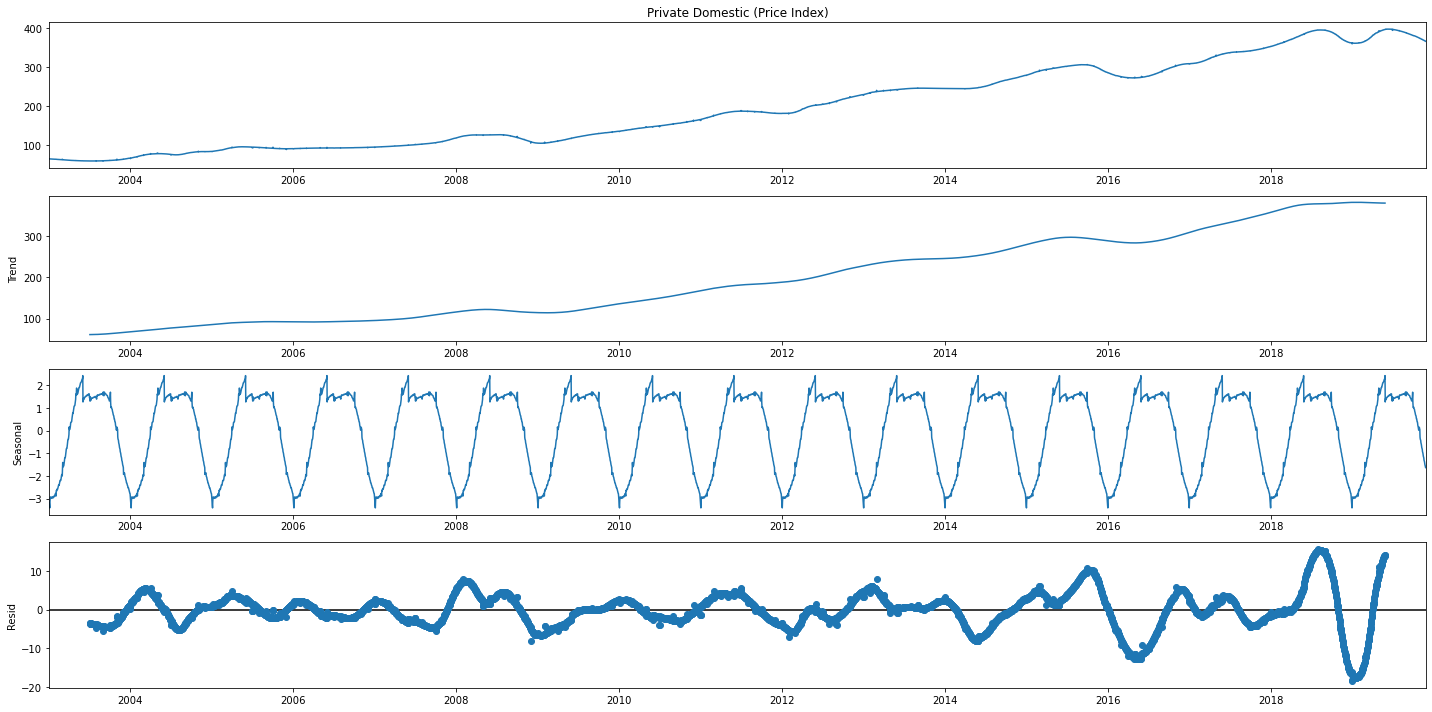

In [18]:
df_series = df.set_index('Date').asfreq('D')
series = pd.Series(df_series['Private Domestic (Price Index)'], index= df_series.index)
results = sm.tsa.seasonal_decompose(series, model='additive',period= 365)
pyplot.rcParams['figure.figsize'] = (20.0, 10.0)
results.plot()
pyplot.show()

* We have used the additive model for decomposition which assumes that the time series data is structured in the following manner: **Time Series Data = Trend + Seasonal + Random**

* We can observe that the seasonal pattern is a regularly repeating pattern and that the trend is upward sloping but it is not a smooth line.

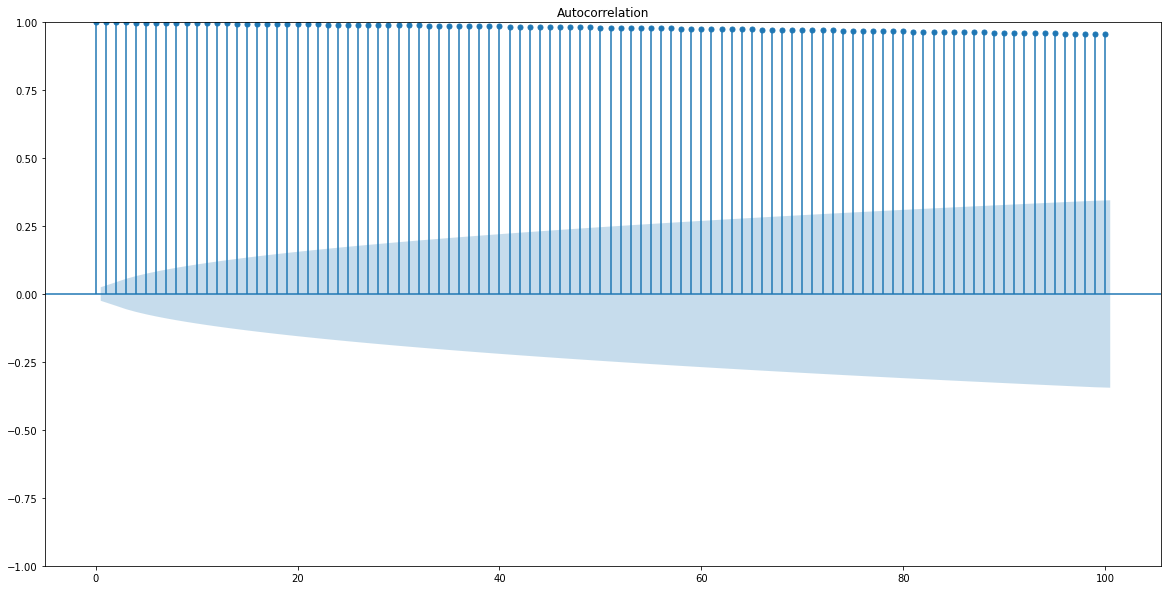

In [19]:
# ACF Plot of Target Variable
plot_acf(series,lags= 100)
pyplot.show()

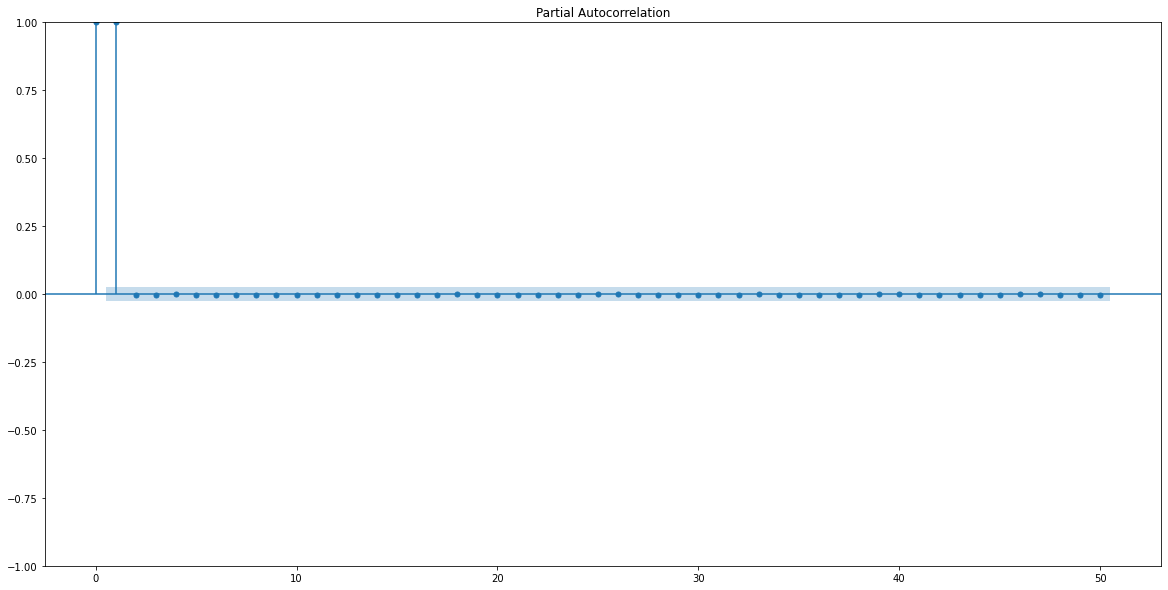

In [20]:
plot_pacf(series, lags=50, method="ywm")
pyplot.show()

In [21]:
df.to_csv("cleaned_data.csv",
              index=False)

**Feature Engineering** and **Feature Selection**. Feature engineering refers to the process of creating new variables from existing ones which capture hidden business insights. Feature selection involves making the right choices about which variable to choose for our forecasting models. Both these skills are a combination of art and science which need some practice to perfect.

## Index:
* Feature Engineering (Lags, Periodic difference, Flags for events etc.)
* Feature Selection Methods (Correlation, Lasso Regression, Recursive Feature Selection,Random Forest, Beta Coefficients)
* Combining Feature Selection Methods


# Feature Engineering & Selection
It is common practice to use different ways to represent data fields in a model, and usually some of these representations are better than others. This is the basic idea behind feature engineering — the process of creating representations of data that increase the effectiveness of a model. We will be discussing some of the tried and tested features created from a multivariate time series data and the rationale behind each of them. The dataset being used here is the same as the previous blog in this series. It is a daily dataset on Hong Kong flat prices along with 12 macro economics variables.

## Index:
* Feature Engineering (Lags, Periodic difference, Flags for events etc.)
* Feature Selection Methods (Correlation, Lasso Regression, Recursive Feature Selection,Random Forest, Beta Coefficients)
* Combining Feature Selection Methods

## Feature Engineering
This is the basic idea behind feature engineering — the process of creating representations of data that increase the effectiveness of a model.
Once the data has been cleaned up, we will create the following additional features:

* 3 lags for each feature
* Daily change for each feature
* A flag for holidays
* Calculate First hand sales price and drop the sales amount variable

* There is a high level of correlation for a large number of lags between the target variable and most of the features.

* For this exercise we created 3 lags for each column with the ‘shift’ function as shown below. Ideally, we should add lags till the point where cross correlation drastically drop.

### Feature 1: Flags for events
Sometimes highlighting key events like holidays helps the model predict better. For example, if we are trying to predict garment sales then a flag for holidays like Christmas, Thanksgiving etc usually help the model predict the sudden peaks during such times better. In our case, we created flags for holidays using the ‘calendar’ function.

In [22]:
df = pd.read_csv("cleaned_data.csv")

In [23]:
# Create Holiday Flag

df['Date'] = pd.to_datetime(df['Date'])
cal = calendar()
holidays = cal.holidays(start=df['Date'].min(), end=df['Date'].max())
df['holidays'] = np.where(df['Date'].dt.date.isin(holidays), 1, 0)
df.head(5)

C:\Users\Data Scientist\AppData\Roaming\Python\Python38\site-packages\pandas\core\algorithms.py:524: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return f(comps, values)


,Date,Private Domestic (Price Index),First hand sales quantity,First hand sales amount,Total completions,Total stock,Total take up,Total vacancy,Unemployment rate (seasonally adjusted) (%),CPI,HIBOR (1-month),M3 (HK$ million),HSI - close,HSI - volume,holidays
0,2003-01-02,64.559769,1854.689208,5.846897e+09,32713.103209,1.092844e+06,19914.083323,74177.818318,7.301525,73.721486,1.44420,3.562189e+06,9365.519531,126907400.0,0
1,2003-01-03,64.506848,1892.762372,5.927523e+09,32713.103209,1.092244e+06,19900.006814,74155.621001,7.299043,73.717079,1.41741,3.562586e+06,9583.849609,291454400.0,0
2,2003-01-04,64.506848,1892.762372,5.927523e+09,32713.103209,1.092244e+06,19900.006814,74155.621001,7.299043,73.717079,1.41741,3.562586e+06,9583.849609,291454400.0,0
3,2003-01-05,64.506848,1892.762372,5.927523e+09,32713.103209,1.092244e+06,19900.006814,74155.621001,7.299043,73.717079,1.41741,3.562586e+06,9583.849609,291454400.0,0
4,2003-01-06,64.453848,1931.338866,5.998876e+09,32713.103209,1.091646e+06,19886.125236,74133.429251,7.296561,73.712684,1.40402,3.563044e+06,9665.959961,234912800.0,0


* To create a flag for events, it is important to have a date column which is in the correct date-time format (example : “YYYY-MM-DD”)
* We create a separate list of dates for holidays and for all the values in the date column in our dataset which has a match with this list, we flag it as a holiday


Apart from these common features, based on business context we should try to create additional features which have a strong relationship with the target variable. For example, we created a new feature ‘First Hand Price’ as the ratio between ‘First Hand sales amount’ and ‘First Hand quantity’.

In [24]:
#Create a new feature =  First hand price
df['First hand sales price'] = df['First hand sales amount']/df['First hand sales quantity']
predictors1 = df.drop(columns=['Date','Private Domestic (Price Index)','holidays','First hand sales amount','First hand sales quantity'],axis=1) # Add  if applicable
predictors1.head(5)

,Total completions,Total stock,Total take up,Total vacancy,Unemployment rate (seasonally adjusted) (%),CPI,HIBOR (1-month),M3 (HK$ million),HSI - close,HSI - volume,First hand sales price
0,32713.103209,1.092844e+06,19914.083323,74177.818318,7.301525,73.721486,1.44420,3.562189e+06,9365.519531,126907400.0,3.152494e+06
1,32713.103209,1.092244e+06,19900.006814,74155.621001,7.299043,73.717079,1.41741,3.562586e+06,9583.849609,291454400.0,3.131678e+06
2,32713.103209,1.092244e+06,19900.006814,74155.621001,7.299043,73.717079,1.41741,3.562586e+06,9583.849609,291454400.0,3.131678e+06
3,32713.103209,1.092244e+06,19900.006814,74155.621001,7.299043,73.717079,1.41741,3.562586e+06,9583.849609,291454400.0,3.131678e+06
4,32713.103209,1.091646e+06,19886.125236,74133.429251,7.296561,73.712684,1.40402,3.563044e+06,9665.959961,234912800.0,3.106071e+06


### Feature 2: Lags
**Lag features** are values at prior time steps. For example lag 1 of a variable at time t is its value from last period, t-1. As the name suggests, the hypothesis here is that the features have a lagged impact on the target variable. The best way to find the optimal number of lags to chose for each field is to look at cross correlation graphs.Cross correlation graphs show the correlation between the target variable (here, private domestic price index of flats) with various lags of raw features (sales, money supply, etc.).

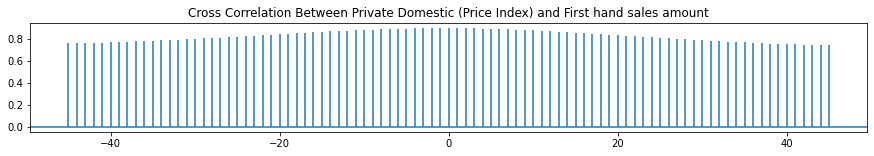

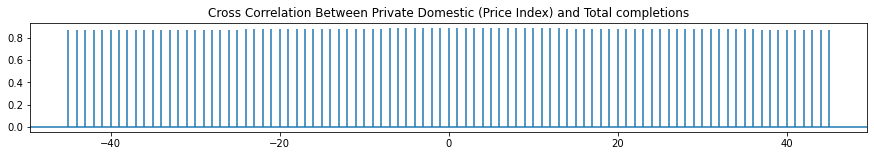

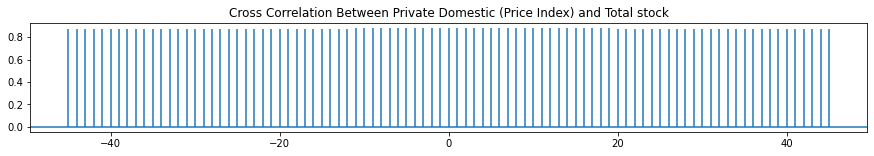

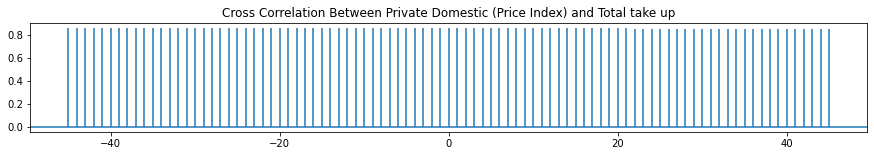

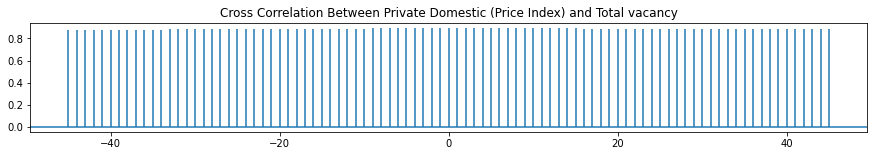

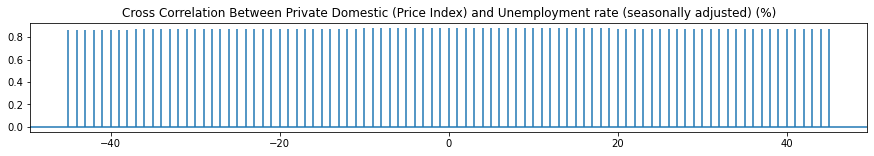

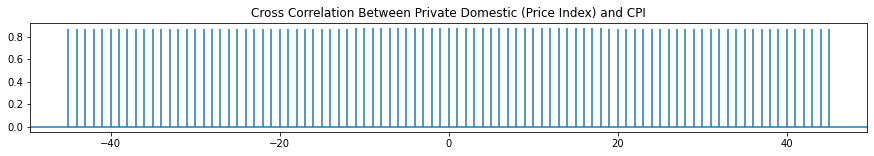

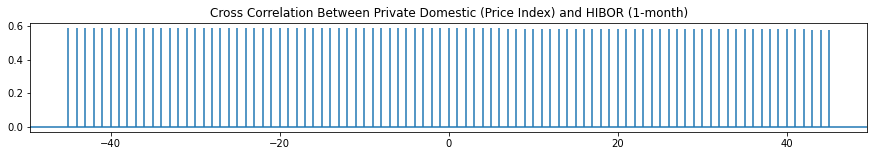

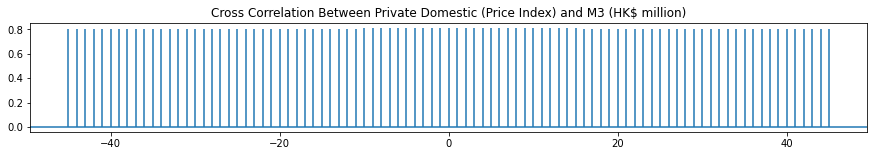

In [25]:
# Check Optimal Number of Lags
for i in range(3,12):
    pyplot.figure(i, figsize=(15,2)) # add this statement before your plot
    pyplot.xcorr(df.iloc[:,2],df.iloc[:,i],maxlags=45, usevlines=1)
    pyplot.title('Cross Correlation Between Private Domestic (Price Index) and '+ df.columns[i])
    pyplot.show()

* There is a high level of correlation for a large number of lags between the target variable and most of the features.

* For this exercise we created 3 lags for each column with the ‘shift’ function as shown below. Ideally, we should add lags till the point where cross correlation drastically drop.

In [26]:
#Engineering features based on creating lags and perdiodic changes of features

#Add Lags
predictors2 = predictors1.shift(1)
predictors2 = predictors2.add_suffix('_Lag1')
predictors3 = predictors1.shift(2)
predictors3 = predictors3.add_suffix('_Lag2')
predictors4 = predictors1.shift(3)
predictors4 = predictors4.add_suffix('_Lag3')

### Feature 3: Periodic Difference
This feature is calculated as the difference between the current value of the variable and its previous value. The expectation is that the change in a variable has a stronger relationship than the raw variable itself. We can calculate the periodic difference using the ‘diff’ function (as shown below).

In [27]:
#Add Periodic Difference
predictors5 = predictors1.diff()
predictors5 = predictors5.add_suffix('_Diff')

predictors = pd.concat([predictors1, predictors2, predictors3,predictors4, predictors5,df['holidays']], axis=1) #Add df['holidays'] if applicable
predictors=predictors.dropna(axis=0, how='any')

predictors.head(10)

,Total completions,Total stock,Total take up,Total vacancy,Unemployment rate (seasonally adjusted) (%),CPI,HIBOR (1-month),M3 (HK$ million),HSI - close,HSI - volume,...,Total take up_Diff,Total vacancy_Diff,Unemployment rate (seasonally adjusted) (%)_Diff,CPI_Diff,HIBOR (1-month)_Diff,M3 (HK$ million)_Diff,HSI - close_Diff,HSI - volume_Diff,First hand sales price_Diff,holidays
3,32713.103209,1.092244e+06,19900.006814,74155.621001,7.299043,73.717079,1.41741,3.562586e+06,9583.849609,291454400.0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0
4,32713.103209,1.091646e+06,19886.125236,74133.429251,7.296561,73.712684,1.40402,3.563044e+06,9665.959961,234912800.0,...,-13.881577,-22.191750,-0.002481,-0.004395,-0.01339,457.835732,82.110352,-56541600.0,-25606.914265,0
5,32713.103209,1.091050e+06,19872.438591,74111.243068,7.294081,73.708301,1.39063,3.563562e+06,9652.400391,267021800.0,...,-13.686645,-22.186184,-0.002481,-0.004383,-0.01339,518.438226,-13.559570,32109000.0,-30096.688654,0
6,32713.103209,1.090457e+06,19858.946877,74089.062450,7.291601,73.703930,1.39732,3.564141e+06,9688.209961,202439200.0,...,-13.491713,-22.180617,-0.002480,-0.004371,0.00669,579.040720,35.809570,-64582600.0,-34301.973468,0
7,32713.103209,1.089865e+06,19845.650096,74066.887400,7.289122,73.699570,1.43080,3.564781e+06,9675.410156,129623200.0,...,-13.296781,-22.175051,-0.002479,-0.004360,0.03348,639.643214,-12.799805,-72816000.0,-38238.405936,0
8,32713.103209,1.089275e+06,19832.548246,74044.717915,7.286643,73.695223,1.43973,3.565481e+06,9721.500000,172862200.0,...,-13.101850,-22.169484,-0.002478,-0.004348,0.00893,700.245708,46.089844,43239000.0,-41920.790237,0
9,32713.103209,1.089275e+06,19832.548246,74044.717915,7.286643,73.695223,1.43973,3.565481e+06,9721.500000,172862200.0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0
10,32713.103209,1.089275e+06,19832.548246,74044.717915,7.286643,73.695223,1.43973,3.565481e+06,9721.500000,172862200.0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0
11,32713.103209,1.088688e+06,19819.641329,74022.553998,7.284165,73.690887,1.42857,3.566242e+06,9834.080078,197967600.0,...,-12.906918,-22.163918,-0.002478,-0.004336,-0.01116,760.848202,112.580078,25105400.0,-45363.138470,0
12,32713.103209,1.088102e+06,19806.929343,74000.395646,7.281688,73.686562,1.43304,3.567063e+06,9796.309570,168152000.0,...,-12.711986,-22.158351,-0.002477,-0.004324,0.00447,821.450696,-37.770508,-29815600.0,-48578.710184,0


In [28]:
# Checking the final predictors data
predictors.describe()

,Total completions,Total stock,Total take up,Total vacancy,Unemployment rate (seasonally adjusted) (%),CPI,HIBOR (1-month),M3 (HK$ million),HSI - close,HSI - volume,...,Total take up_Diff,Total vacancy_Diff,Unemployment rate (seasonally adjusted) (%)_Diff,CPI_Diff,HIBOR (1-month)_Diff,M3 (HK$ million)_Diff,HSI - close_Diff,HSI - volume_Diff,First hand sales price_Diff,holidays
count,6170.000000,6.170000e+03,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6.170000e+03,6170.000000,6.170000e+03,...,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6.170000e+03,6.170000e+03,6170.000000
mean,15362.090591,1.106761e+06,13925.883127,52796.980027,4.196622,88.221913,1.059688,8.386086e+06,20801.769474,1.459849e+09,...,-3.493991,-0.849352,-0.000656,0.005887,0.000106,1731.716944,2.808763,3.443983e+05,8.044495e+02,0.000162
std,6386.362406,5.069861e+04,6173.362266,8987.750039,1.266418,12.710889,1.188195,3.551436e+06,5298.565533,8.072528e+08,...,25.497684,21.351499,0.135690,0.262035,0.123449,5414.715337,234.974521,3.691192e+08,4.286143e+05,0.012731
min,6792.576078,1.006630e+06,-1657.914651,41975.928483,2.800000,71.700000,0.040180,3.548561e+06,8409.009766,0.000000e+00,...,-86.777479,-58.464668,-1.391505,-3.448806,-2.151193,-27648.009925,-2061.228516,-2.044749e+09,-1.656848e+07,0.000000
25%,9941.410399,1.073219e+06,9516.760436,45719.758066,3.136014,75.568178,0.213383,5.292351e+06,17081.262207,9.158194e+08,...,-10.582988,-10.430187,-0.001419,0.000000,-0.001070,0.000000,-45.751953,-8.913138e+07,-3.392260e+04,0.000000
50%,13750.062447,1.106819e+06,12666.330408,49957.909895,3.638680,86.249741,0.347140,7.668395e+06,21654.160156,1.502400e+09,...,0.000000,0.000000,-0.000191,0.006455,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
75%,19061.267131,1.142388e+06,16988.427021,62792.720675,5.069727,100.319672,1.747680,1.147977e+07,23982.609375,1.967891e+09,...,8.530563,0.652074,0.000000,0.011809,0.000720,4007.036727,71.484863,8.203960e+07,3.433064e+04,0.000000
max,32713.103209,1.214837e+06,28187.536217,74155.621001,7.800000,111.000000,4.044290,1.470108e+07,33154.121094,3.554766e+09,...,58.438187,97.903823,1.388410,3.475201,2.166863,34181.322349,2332.539063,2.533196e+09,2.214944e+07,1.000000


In [29]:
predictors.to_csv("predictors.csv",
              index=False)

# Feature Selection Methods
Feature selection is a critical step for most data science projects as it enables the models to train faster, reduces the complexity and makes it easier to interpret. It has the potential to improve model performance and reduce the problem of overfitting if the optimal set of features are chosen. We will be discussing various methods and their respectives rules for selecting the best features.


The next step is to perform featue selection using the following techniques:

1. Select the top n features based on feature importance from random forest
2. Select the top n features based on absolute correlation with target variable
3. Select the features identified by Lasso regression
4. Perform recursive feature selection and use cross validation to identify the best number of features
5. Select the top n features based on absolute value of beta coefficients of features

The final features are the ones which were selected in at least 3 out of 5 models.

In [30]:
predictors = pd.read_csv("predictors.csv")

#Setting up Target field
Target = df.iloc[3: , [1]]
Target.head(5)

,Private Domestic (Price Index)
3,64.506848
4,64.453848
5,64.400768
6,64.347610
7,64.294373


### Method 1: Variable Importance from Random Forest
Random forests consist of multiple decision trees, each of them built over a random sample of the observations from the dataset and a random sample of the features. This random selection guarantees that the trees are not correlated and therefore less susceptible to over-fitting. For forecasting exercises, we use variable importance feature of random forest which measures how much the accuracy decreases when a variable is excluded.

C:\Users\DATASC~1\AppData\Local\Temp/ipykernel_23516/4249542300.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(predictors, Target)


<AxesSubplot:>

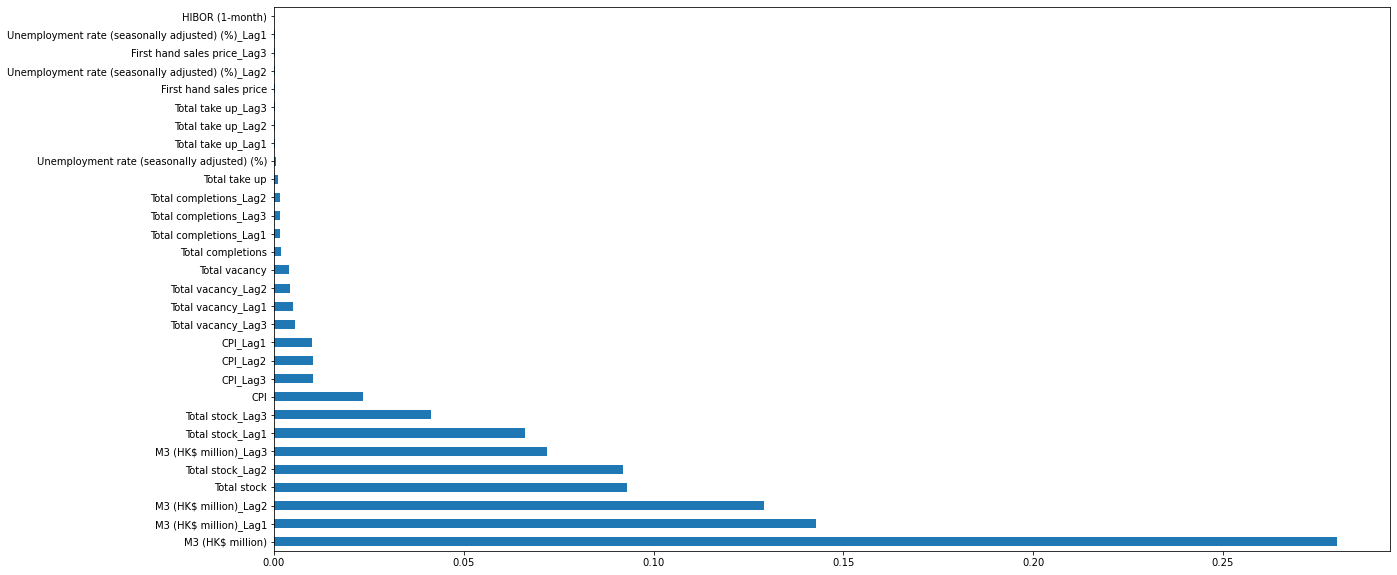

In [31]:
#1.Select the top n features based on feature importance from random forest

np.random.seed(10)

# define the model
model = RandomForestRegressor(random_state = random.seed(10))
# fit the model
model.fit(predictors, Target)

# get importance
features = predictors
importances = model.feature_importances_
indices = np.argsort(importances)

feat_importances = pd.Series(model.feature_importances_, index=predictors.columns)
feat_importances.nlargest(30).plot(kind='barh')

In [32]:
#Final Features from Random Forest (Select Features with highest feature importance)
rf_top_features = pd.DataFrame(feat_importances.nlargest(7)).axes[0].tolist()
rf_top_features

['M3 (HK$ million)',
 'M3 (HK$ million)_Lag1',
 'M3 (HK$ million)_Lag2',
 'Total stock',
 'Total stock_Lag2',
 'M3 (HK$ million)_Lag3',
 'Total stock_Lag1']

* We check the feature importance plot for top 30 variables based on variable importance. We can see that 2 period lag of ´M3 (HK$ million)´ is the most important feature and after the 7th feature the variable importance falls. So we chose 7 features for this analysis.

We can optimise the random forest model by tuning the parameters in case the features selected by the default model are not satisfactory. This is an example of embedded method which work by evaluating a subset of features using a machine learning algorithm that employs a search strategy to look through the space of possible feature subsets, evaluating each subset based on the quality of the performance of a given algorithm.

### Method 2: Pearson Correlation


In [33]:
#2.Select the top n features based on absolute correlation with target variable
corr_data1 = pd.concat([Target,predictors],axis = 1)
corr_data = corr_data1.corr()
corr_data = corr_data.iloc[: , [0]]
corr_data.columns.values[0] = "Correlation"
corr_data = corr_data.iloc[corr_data.Correlation.abs().argsort()] 
corr_data = corr_data[corr_data['Correlation'].notna()]
corr_data = corr_data.loc[corr_data['Correlation'] != 1]
corr_data.tail(20)

,Correlation
HSI - close,0.797366
HSI - close_Lag1,0.797565
HSI - close_Lag2,0.797761
HSI - close_Lag3,0.797963
Unemployment rate (seasonally adjusted) (%),-0.839230
Unemployment rate (seasonally adjusted) (%)_Lag1,-0.839325
Unemployment rate (seasonally adjusted) (%)_Lag2,-0.839423
Unemployment rate (seasonally adjusted) (%)_Lag3,-0.839516
Total stock_Lag3,0.960251
Total stock_Lag2,0.960356


We calculate the correlation of each feature with the target variable and sort the features by the absolute values of their correlation.

In [34]:
#Select Features with greater than 90% absolute correlation
corr_data2 = corr_data.loc[corr_data['Correlation'].abs() > .9]
corr_top_features = corr_data2.axes[0].tolist()

We select the 12 features with greater than 90% absolute correlation. Based on the business context the threshold can be modified.

### Method 3: L1 regularisation using Lasso regression
Lasso or L1 regularisation is based on the property that is able to shrink some of the coefficients in a linear regression to zero. Therefore, such features can be removed from the model. This is another example of an embedded method of feature selection.

In [35]:
np.random.seed(10)

estimator = LassoCV(cv=5, normalize=True)

sfm = SelectFromModel(estimator, prefit=False, norm_order=1, max_features=None)

sfm.fit(predictors, Target)

feature_idx = sfm.get_support()
Lasso_features = predictors.columns[feature_idx].tolist()
Lasso_features

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1572: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\ProgramD

['Total completions',
 'CPI',
 'HIBOR (1-month)',
 'HSI - close',
 'CPI_Lag1',
 'HSI - close_Lag1',
 'Total completions_Lag2',
 'CPI_Lag2',
 'HIBOR (1-month)_Lag2',
 'Total completions_Lag3',
 'CPI_Lag3',
 'HSI - close_Lag3',
 'Total completions_Diff',
 'Total stock_Diff',
 'Total take up_Diff',
 'Total vacancy_Diff',
 'CPI_Diff',
 'M3 (HK$ million)_Diff']

We specify the Lasso Regression model and then use the ‘selectFromModel’ function, which will select in theory the features which coefficients are non-zero

### Method 4: Recursive Feature Selection (RFE)
RFE is a greedy optimization algorithm which repeatedly creates models and separates out the best or the worst performing feature at each iteration. It constructs the next model with the remaining features until all the features have been used. It finally ranks the features based on the order of their elimination.

In [36]:
#4.Perform recursive feature selection and use cross validation to identify the best number of features
#Feature ranking with recursive feature elimination and cross-validated selection of the best number of features
rfe_selector = RFE(estimator=LinearRegression(), n_features_to_select= 7, step=10, verbose=5)
rfe_selector.fit(predictors, Target)
rfe_support = rfe_selector.get_support()
rfe_feature = predictors.loc[:,rfe_support].columns.tolist()
rfe_feature

Fitting estimator with 56 features.
Fitting estimator with 46 features.
Fitting estimator with 36 features.
Fitting estimator with 26 features.
Fitting estimator with 16 features.


['Unemployment rate (seasonally adjusted) (%)',
 'CPI',
 'Unemployment rate (seasonally adjusted) (%)_Lag1',
 'CPI_Lag1',
 'HIBOR (1-month)_Lag1',
 'Unemployment rate (seasonally adjusted) (%)_Diff',
 'CPI_Diff']

We use linear regression to perform the recursive feature selection and select top 7 ranked fields. This is a wrapper method of feature selection that attempts to find the “optimal” feature subset by iteratively selecting features based on the model performance.

### Method 5: Beta Coefficients
The absolute value of the coefficients of a standardized regression, also known as beta coefficients, can be considered a proxy for feature importance. This is a type of filter method of feature selection.

In [37]:
#5.Select the top n features based on absolute value of beta coefficients of features

# define standard scaler
scaler = StandardScaler()
# transform x data
scaled_predictors = scaler.fit_transform(predictors)
scaled_Target = scaler.fit_transform(Target)

sr_reg = LinearRegression(fit_intercept = False).fit(scaled_predictors, scaled_Target)
coef_table = pd.DataFrame(list(predictors.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",sr_reg.coef_.transpose())
coef_table = coef_table.iloc[coef_table.Coefs.abs().argsort()] 


sr_data2 = coef_table.tail(10)
sr_top_features = sr_data2.iloc[:,0].tolist()
sr_top_features

['Total take up_Lag3',
 'Total stock_Lag2',
 'Total stock_Lag3',
 'Total vacancy_Lag2',
 'Total completions_Lag2',
 'Total vacancy_Lag3',
 'Total completions_Lag3',
 'Total completions_Diff',
 'Total completions',
 'Total completions_Lag1']

### Combining Feature Selection Methods
Each of these models are good at capturing a particular type of relationship between the features and target variable. For example, beta coefficients are good at identifying the linear relationships while random forest is suitable for spotting non-linear bonds. Based on my experience, I found that trying to combine the results from multiple methods led to more robust results. We will look at one of the ways to do so in this section.

In [38]:
# Combining features from all the models

combined_feature_list = sr_top_features + Lasso_features + corr_top_features + rf_top_features + rfe_feature

combined_feature = {x:combined_feature_list.count(x) for x in combined_feature_list}
combined_feature_data = pd.DataFrame.from_dict(combined_feature,orient='index')

combined_feature_data.rename(columns={ combined_feature_data.columns[0]: "number_of_models" }, inplace = True)


combined_feature_data = combined_feature_data.sort_values(['number_of_models'], ascending=[False])

combined_feature_data.head(100)

,number_of_models
CPI,3
Total stock_Lag2,3
CPI_Lag1,3
M3 (HK$ million)_Lag3,2
Total stock_Lag1,2
Total stock,2
M3 (HK$ million),2
CPI_Lag2,2
M3 (HK$ million)_Lag1,2
M3 (HK$ million)_Lag2,2


In [39]:
#Final Features: features which were selected in atleast 3 models

combined_feature_data = combined_feature_data.loc[combined_feature_data['number_of_models'] > 2]
final_features = combined_feature_data.axes[0].tolist()
final_features

['CPI', 'Total stock_Lag2', 'CPI_Lag1']

In [40]:
# Final Master Data on Selected Features
features = predictors[predictors.columns.intersection(final_features)]
features_date =  df.iloc[3:,0]
features_final = features.set_index(features_date).asfreq('D')
features_final.head(10)         

,CPI,CPI_Lag1,Total stock_Lag2
Date,,,
2003-01-05,73.717079,73.717079,1.092244e+06
2003-01-06,73.712684,73.717079,1.092244e+06
2003-01-07,73.708301,73.712684,1.092244e+06
2003-01-08,73.703930,73.708301,1.091646e+06
2003-01-09,73.699570,73.703930,1.091050e+06
2003-01-10,73.695223,73.699570,1.090457e+06
2003-01-11,73.695223,73.695223,1.089865e+06
2003-01-12,73.695223,73.695223,1.089275e+06
2003-01-13,73.690887,73.695223,1.089275e+06


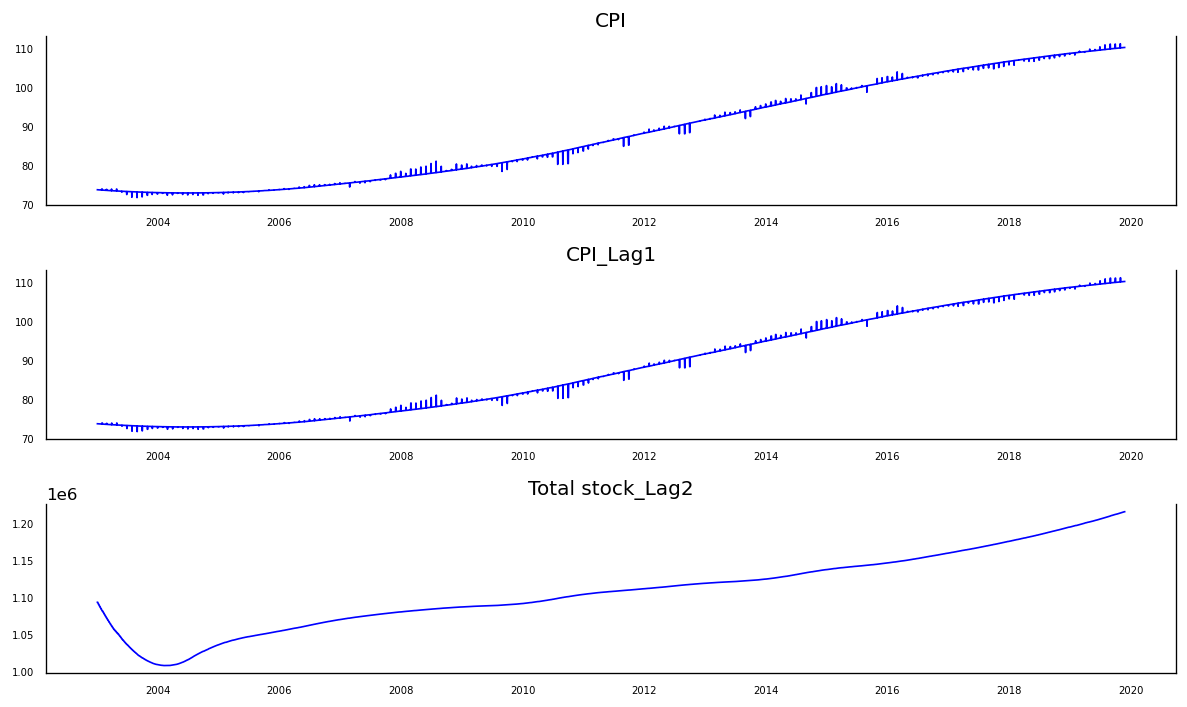

In [41]:
# Plot all Final Features
fig, axes = pyplot.subplots(nrows=3, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    plot_data = features_final[features_final.columns[i]]
    ax.plot(plot_data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(features_final.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

pyplot.tight_layout();

In [42]:
# Final Target Variable Dataset
target_final = series.iloc[3:,]
target_final.tail(5)

Date
2019-11-22    366.678619
2019-11-23    366.678619
2019-11-24    366.678619
2019-11-25    366.246194
2019-11-26    365.810997
Freq: D, Name: Private Domestic (Price Index), dtype: float64

In [43]:
features_final.to_csv("feature_final.csv",
                      index=False)

target_final.to_csv("target_final.csv",
              index=False)

# Data Preparation for Forecasting Engine


Forecasting essentially comes under time series analysis. But artificial intelligence can be a force multiplier in terms of heightening the accuracy of forecasting as it has the capacity to study and discover fascinating patterns in the data automatically. 
There are two key ingredients in our forecasting recipe:
1. Intelligently engineering and identifying key drivers of the target variable
2. Using these drivers in an ensemble modelling approach consisting of successful time series and AI models


We will be deep-diving into the final predictive engine in our driver based forecasting approach in this blog. It is made up of 10 models (5 time series and 5 AI models) and in the end we take average of all the model predictions as the final forecast of our predictive engine. Given the large number of models, we will give a brief introduction to each along with details on how to implement them in python. In a separate blog we will discuss the best practices on optimizing each of these models.

## List of Models:
1. SARIMA (Univariate Time Series)
2. Holt Winters Exponential Smoothing (HWES)or Triple Smoothing (Univariate Time Series)
3. SARIMAX (Multivariate Time Series)
4. VAR (Multivariate Time Series)
5. VECM (Multivariate Time Series)
6. LSTM (Univariate Time Series)
7. Random Forest (Multivariate AI)
8. XGBoost (Multivariate AI)
9. Linear Regression (Multivariate AI)
10. SVR (Multivariate AI)

In [44]:
features_final= pd.read_csv("feature_final.csv")
target_final= pd.read_csv("target_final.csv")

In [45]:
# Function to check stationarity

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    
    def adjust(val, length= 6):
        return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [46]:
# Data Prep

AI_Model_data = pd.concat([target_final, features_final], axis=1, sort=False)

# Check stationarity

# ADF Test on each column
for name, column in AI_Model_data.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Private Domestic (Price Index)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.2796
 No. Lags Chosen       = 34
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.6385. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "CPI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 7.1937
 No. Lags Chosen       = 33
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 1.0. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "CPI_Lag1" 
    -----------------------------------------------
 Null H

In [47]:
# 1st difference
AI_Model_data_differenced = AI_Model_data.diff().dropna()


# Check stationarity

# ADF Test on each column
#for name, column in AI_Model_data_differenced.iteritems():
    #adfuller_test(column, name=column.name)
    #print('\n')

x = AI_Model_data_differenced.values #returns a numpy array


# Standardise Datasets

standard_scaler = StandardScaler()
x_scaled = standard_scaler.fit_transform(x)
scaled_AI_Model_data = pd.DataFrame(x_scaled)
scaled_AI_Model_data.columns = AI_Model_data_differenced.columns



# Check stationarity on diffrenced and scaled data

# ADF Test on each column
for name, column in scaled_AI_Model_data.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Private Domestic (Price Index)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.489
 No. Lags Chosen       = 33
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0083. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CPI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -21.007
 No. Lags Chosen       = 34
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CPI_Lag1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationar

In [48]:
# Separate out traget and features

scaled_AI_Model_Target = scaled_AI_Model_data.iloc[:,0]
scaled_AI_Model_Features = scaled_AI_Model_data.iloc[:,1:]

#Mean and Standard Deviation
mean_target = AI_Model_data_differenced.iloc[:,0].mean()
std_target = AI_Model_data_differenced.iloc[:,0].std()


scaled_AI_Model_Features

,CPI,CPI_Lag1,Total stock_Lag2
0,-0.039240,-0.022465,-0.228627
1,-0.039196,-0.039237,-0.228627
2,-0.039151,-0.039192,-7.119172
3,-0.039106,-0.039147,-7.095024
4,-0.039061,-0.039102,-7.070877
...,...,...,...
6164,0.000544,0.000571,0.912383
6165,-0.022469,0.000547,0.913093
6166,-0.022469,-0.022465,0.913804
6167,0.000520,-0.022465,-0.228627


### 1.SARIMA
Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is a forecasting method for univariate time series data that works well with data having a seasonal component. It supports both autoregressive and moving average elements while the integrated element refers to differencing allowing the method to support non-stationary time series data. There are a total of 7 parameters that require configuration for this model:

* **p**: Trend autoregression order.
* **d**: Trend difference order.
* **q**: Trend moving average order.
* **P**: Seasonal autoregressive order.
* **D**: Seasonal difference order.
* **Q**: Seasonal moving average order.
* **m**: The number of time steps for a single seasonal period.

In [49]:
# fitting a stepwise model to find the best paramters for SARIMA:
stepwise_fit = pm.auto_arima(target_final, start_p=1, start_q=1, max_p=3, max_d=2,max_q=3,m=7,
                             start_P=0,start_Q=0,max_P=3, max_D=3,max_Q=3, seasonal=True, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[7]             : AIC=1604.833, Time=0.59 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=6911.109, Time=0.18 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=4914.357, Time=0.53 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=1784.735, Time=0.79 sec
 ARIMA(1,2,1)(1,0,0)[7]             : AIC=1536.204, Time=1.01 sec
 ARIMA(1,2,1)(2,0,0)[7]             : AIC=1476.352, Time=1.74 sec
 ARIMA(1,2,1)(3,0,0)[7]             : AIC=1433.283, Time=3.10 sec
 ARIMA(1,2,1)(3,0,1)[7]             : AIC=1357.471, Time=6.61 sec
 ARIMA(1,2,1)(2,0,1)[7]             : AIC=1356.189, Time=3.34 sec
 ARIMA(1,2,1)(1,0,1)[7]             : AIC=1356.632, Time=1.91 sec
 ARIMA(1,2,1)(2,0,2)[7]             : AIC=1360.442, Time=3.55 sec
 ARIMA(1,2,1)(1,0,2)[7]             : AIC=1356.117, Time=3.64 sec
 ARIMA(1,2,1)(0,0,2)[7]             : AIC=1500.438, Time=1.80 sec
 ARIMA(1,2,1)(1,0,3)[7]             : AIC=1357.328, Time=6.33 sec
 ARIMA(1,2,1)(0,0,1)[7]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 6170
Model:             SARIMAX(3, 2, 1)x(1, 0, [1, 2], 7)   Log Likelihood                -467.916
Date:                                Thu, 09 Dec 2021   AIC                            951.831
Time:                                        14:04:20   BIC                           1005.648
Sample:                                             0   HQIC                           970.494
                                               - 6170                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3081      0.005    -61.927      0.000      -0.318      -0.298
ar.L2         -0.2450      0.006    -40.731      0.000      -0.257      -0.233
ar.L3         -0.1784      0.007    -25.399      0.000      -0.192      -0.165
ma.L1         -0.9490      0.003   -282.416      0.000      -0.956      -0.942
ar.S.L7        0.8787      0.019     45.796      0.000       0.841       0.916
ma.S.L7       -0.7965      0.025    -32.322      0.000      -0.845      -0.748
ma.S.L14       0.0243      0.018      1.337      0.181      -0.011       0.060
sigma2         0.0681      0.000    217.846      0.000       0.067       0.069
===================================================================================
Ljung-Box (L1) (Q):                   3.36   Jarque-Bera (JB):            390400.43
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        41.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We find the optimal values for each parameter by doing a grid search that fits a range of parameter values the developer specifies. We select the set of parameter values with the lowest AIC score.

### 2. Holt-Winters Exponential Smoothing (HWES) or Triple Smoothing

The Holt-Winters technique is based on the following three forecasting techniques:
1. Weighted Averages
2. Simple exponential smoothing
3. Holt’s linear method

Holt-Winters Exponential Smoothing is an upgraded version of these models as it can be used in time series data that exhibits both trend and a seasonal behaviour. There are two variations to this method:

1. Additive method: It is preferred when the seasonal variations are roughly constant through the series
2. Multiplicative method: It is preferred when the seasonal variations are changing proportional to the level of the series.

In [50]:
# Holt Winter’s Exponential Smoothing (HWES)or Triple Smoothing
# fit model

random.seed(10)

model = ExponentialSmoothing(series, trend = 'add',seasonal= 'add', seasonal_periods= 7)
model_fit = model.fit()
# make prediction
HWES_Forecast = pd.DataFrame(model_fit.forecast(steps=365))
HWES_Forecast.columns = ['HWES_Forecast']
HWES_Forecast.head(5)


#Plot
#HWES_Forecast.plot(marker='o', color='red', legend=True)
#model_fit.fittedvalues.plot(marker='o',  color='blue')

,HWES_Forecast
2019-11-27,365.626635
2019-11-28,365.353877
2019-11-29,365.099609
2019-11-30,364.781787
2019-12-01,364.448205


In [51]:
# SARIMA

# Using parameters automatically based on grid serach
SARIMA_Forecast = pd.DataFrame(stepwise_fit.predict(n_periods= 365))
SARIMA_Forecast.columns = ['SARIMA_Forecast']
SARIMA_Forecast.index = HWES_Forecast.index
SARIMA_Forecast.head(5)


# Manually fit the model
#sarima_model = SARIMAX(series, order=(5, 2, 2), seasonal_order=(0, 0, 1, 7))
#sarima_model_fit = sarima_model.fit(disp=False)
# make prediction
#SARIMA_Forecast = model_fit.predict(len(data), len(data))
#print(yhat)

,SARIMA_Forecast
2019-11-27,365.492322
2019-11-28,365.177860
2019-11-29,364.831711
2019-11-30,364.650480
2019-12-01,364.476689


In case we are not satisfied with the set of parameters providing the lowest AIC, we can manually fit the model with our prefered set of parameter values.

### 3. SARIMAX 
is similar to SARIMA and stands for seasonal autoregressive integrated moving average with exogenous factors. The key difference between SARIMA and SARIMAX is the exogenous factors. As highlighted in the previous blog, we chose a set of 3 drivers of our target variable and these will be the exogenous factors we will be using for our SARIMAX model.

Before we fit the SARIMAX model, we need to make sure that exogenous factors and target variables are stationary and we will also standardize them to make sure they are on the same scale.

All the features as well as the target variable are non-stationary and so we first difference to make them stationary. We also standardize them as mentioned previously.

After differencing and standardising the dataset, we can see that all the fields are stationary and we will use them to fit the SARIMAX model. The parameters for SARIMAX model are the same as SARIMA and hence, we use the same grid search approach to find the optimal values on the differenced and standardised dataset.

In [52]:
# fitting a stepwise model to find the best paramters for SARIMAX:
stepwise_fit_2 = pm.auto_arima(scaled_AI_Model_Target, start_p=1, start_q=1, max_p=3, d=0,max_q=3,m=7,
                             start_P=0,start_Q=0,max_P=3, max_D=3,max_Q=3, seasonal=True, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise
stepwise_fit_2.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=16872.957, Time=2.36 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=17510.864, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=17170.475, Time=0.59 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=17268.196, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=17508.864, Time=0.04 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=17156.758, Time=1.45 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=17269.647, Time=1.29 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=16450.197, Time=2.87 sec
 ARIMA(1,0,1)(2,0,1)[7] intercept   : AIC=16434.297, Time=4.79 sec
 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=16839.982, Time=2.73 sec
 ARIMA(1,0,1)(3,0,1)[7] intercept   : AIC=16429.744, Time=11.82 sec
 ARIMA(1,0,1)(3,0,0)[7] intercept   : AIC=16611.506, Time=5.82 sec
 ARIMA(1,0,1)(3,0,2)[7] intercept   : AIC=16390.660, Time=21.90 sec
 ARIMA(1,0,1)(2,0,2)[7] intercept   : AIC=16351.653, Time=9.73 sec
 ARIMA(1,0,1)(1,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 6169
Model:             SARIMAX(3, 0, 3)x(1, 0, 3, 7)   Log Likelihood               -7806.318
Date:                           Thu, 09 Dec 2021   AIC                          15634.635
Time:                                   14:20:53   BIC                          15708.636
Sample:                                        0   HQIC                         15660.297
                                          - 6169                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5307      0.064      8.334      0.000       0.406       0.655
ar.L2          0.9745      0.090     10.796      0.000       0.798       1.151
ar.L3         -0.5124      0.030    -17.296      0.000      -0.570      -0.454
ma.L1         -0.8683      0.064    -13.574      0.000      -0.994      -0.743
ma.L2         -0.9514      0.115     -8.305      0.000      -1.176      -0.727
ma.L3          0.8589      0.053     16.238      0.000       0.755       0.963
ar.S.L7        0.8884      0.024     37.480      0.000       0.842       0.935
ma.S.L7       -0.8233      0.027    -30.858      0.000      -0.876      -0.771
ma.S.L14      -0.0033      0.023     -0.143      0.886      -0.049       0.042
ma.S.L21       0.0232      0.019      1.237      0.216      -0.014       0.060
sigma2         0.7349      0.003    211.952      0.000       0.728       0.742
===================================================================================
Ljung-Box (L1) (Q):                   0.70   Jarque-Bera (JB):            401891.38
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        42.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Once we have obtained the optimal values of the parameters, we can fit the model. The critical parameter needed for this model is ‘exog’ which is the dataset of exogenous regressors. In our case, the regressors are the three drivers we selected in our second blog of this series. While using the fitted model to forecast, we will need to provide the forecasts of the drivers as an input to the model. We generate these driver forecasts using the SARIMA model. Please note that the driver forecasts are based on the standardised and stationary data. These driver forecasts will be leveraged in all the multivariate AI models as well.

In [53]:
#Driver Forecast using SARIMA

forecast_index = pd.date_range('2019/11/27', '2020/11/25')

driver_forecasts = pd.DataFrame(index=forecast_index, columns= features_final.columns)

scaled_AI_Model_Features_1 = scaled_AI_Model_Features.copy()
date_index = pd.date_range('2003-01-06', '2019/11/26')
scaled_AI_Model_Features_1.index = date_index


for i in range(len(features_final.columns)):
    df_series = scaled_AI_Model_Features_1.asfreq('D')
    series_features = pd.Series(df_series.iloc[:,i], index= df_series.index)
    stepwise_fit_features = pm.auto_arima(series_features, start_p=1, start_q=1, max_p=2, max_d=2,max_q=2,m=7,
                                                                         start_P=0,start_Q=0,max_P=2, max_D=2,max_Q=2, seasonal=True, trace=True,
                                                                         error_action='ignore',  # don't want to know if an order does not work
                                                                         suppress_warnings=True,  # don't want convergence warnings
                                                                         stepwise=True)  # set to stepwise

    SARIMA_Forecast_features = stepwise_fit_features.predict(n_periods= 365)
    #Add to driver forecast dataset
    driver_forecasts.iloc[:,i] = SARIMA_Forecast_features

driver_forecasts.head(5)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=15889.866, Time=1.42 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=17510.864, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=17212.642, Time=0.43 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=16878.910, Time=0.98 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=17508.864, Time=0.04 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=15891.684, Time=3.11 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=15891.683, Time=5.13 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=15893.682, Time=3.84 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=16880.000, Time=0.59 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=17210.645, Time=0.31 sec
 ARIMA(2,0,1)(0,0,0)[7] intercept   : AIC=15857.511, Time=1.72 sec
 ARIMA(2,0,1)(1,0,0)[7] intercept   : AIC=15858.758, Time=2.85 sec
 ARIMA(2,0,1)(0,0,1)[7] intercept   : AIC=15858.750, Time=2.84 sec
 ARIMA(2,0,1)(1,0,1)[7] intercept   : AIC=15860.657, Time=6.14 sec
 ARIMA(2,0,0)(0,0,0

,CPI,CPI_Lag1,Total stock_Lag2
2019-11-27,0.115778,0.119737,0.859090
2019-11-28,0.041200,0.049168,0.874913
2019-11-29,0.029060,0.017303,0.913358
2019-11-30,0.002793,0.002932,0.915247
2019-12-01,-0.005188,-0.003533,0.914574


The final step is to fit the model using the optimal parameter values and the stationary and standardised historical values of target variable and drivers. We then use the fitted model and the driver forecasts to predict the future. As the model forecasts are based on the differenced and standardised dataset, we need to de-standardise it and undo the first differencing to get the final forecasts.

In [54]:
# Data Prep
dataset = pd.DataFrame(scaled_AI_Model_Target).values
dataset = dataset.astype('float32')
Latest_target = target_final.tail(1).values.tolist()

In [55]:
# SARIMAX 
# contrived dataset
data1 = scaled_AI_Model_Target
data2 = scaled_AI_Model_Features
# fit model
model = SARIMAX(data1, exog=data2, order=stepwise_fit_2.order, seasonal_order=stepwise_fit_2.seasonal_order)
model_fit = model.fit(disp=False)
# make prediction
exog2 = driver_forecasts
SARIMAX_Forecast = pd.DataFrame(model_fit.predict(len(data1),len(data1)+364, exog=exog2))
SARIMAX_Forecast.columns = ['Raw_Forecast']
SARIMAX_Forecast['SARIMAX_Forecast_De_Standardise_R_Sum'] = SARIMAX_Forecast['Raw_Forecast'].cumsum()
SARIMAX_Forecast['SARIMAX_Forecast'] = SARIMAX_Forecast['SARIMAX_Forecast_De_Standardise_R_Sum'] + Latest_target[0]

SARIMAX_Forecast.index = HWES_Forecast.index
SARIMAX_Forecast.head(5)
#print(SARIMAX_Forecast)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Raw_Forecast,SARIMAX_Forecast_De_Standardise_R_Sum,SARIMAX_Forecast
2019-11-27,-1.173901,-1.173901,364.637095
2019-11-28,-1.249975,-2.423877,363.387120
2019-11-29,-1.288677,-3.712554,362.098443
2019-11-30,-0.728539,-4.441093,361.369904
2019-12-01,-0.756244,-5.197337,360.613660


### 4. VAR
Vector Autoregression (VAR) is a forecasting algorithm that can be used when two or more time series influence each other. It is called an autoregressive model because each variable is modeled as a function of the past values, that is the predictors are nothing but their own lags. To understand VAR better, kindly go through this lesson from Penn State University.

As VAR model automatically calculates lags of the variables, we cannot add lags of the variables as a separate variable in the model. Hence, we drop the variable: ‘M3 (HK$ million)_Lag1' before training the model as we already have ‘M3 (HK$ million)’ as a variable. And similar to the SARIMAX model, we need to make the dataset stationary before modelling. We difference the dataset to make it stationary.

In [56]:
# Data Prep for VAR/VECM - First Difference and check stationarity

# Data Prep for VAR - check stationarity

varma_vecm_data = pd.concat([target_final, features_final], axis=1, sort=False)
varma_vecm_data  = varma_vecm_data.drop(columns=['Total stock_Lag2'])

# 1st difference
varma_vecm_data_differenced = varma_vecm_data.diff().dropna()

# ADF Test on each column
for name, column in varma_vecm_data_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Private Domestic (Price Index)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.489
 No. Lags Chosen       = 33
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0083. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CPI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -21.007
 No. Lags Chosen       = 34
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CPI_Lag1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationar

The next part is to select the right order of the VAR model. We use the ‘select_order’ function to iteratively fit increasing orders of VAR model and pick the order that gives a model with least AIC. We then fit the VAR model on the stationary dataset with the optimal number of lags. We use the fitted model to forecast the change in target variable and then undo the differencing to get the final forecasts.

In [57]:
#VAR Model

model = VAR(varma_vecm_data_differenced)
lag_selection_VAR = model.select_order(maxlags=12)

list(lag_selection_VAR.selected_orders.values())[0]


# Get the lag order
lag_order = list(lag_selection_VAR.selected_orders.values())[0]

model_fitted = model.fit(lag_order)


# Input data for forecasting
forecast_input = varma_vecm_data_differenced.values[-lag_order:]
forecast_input

# Forecast
VAR_FC = model_fitted.forecast(y=forecast_input, steps= 365)
VAR_FC_2 = pd.DataFrame(VAR_FC , index= driver_forecasts.index, columns=varma_vecm_data_differenced.columns + '_1d')
VAR_FC_2


#VAR Forecast

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(varma_vecm_data, VAR_FC_2, second_diff=False)
VAR_Forecast = pd.DataFrame(df_results['Private Domestic (Price Index)_forecast'])
VAR_Forecast.columns = ['VAR_Forecast']
VAR_Forecast.index = HWES_Forecast.index
VAR_Forecast.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


,VAR_Forecast
2019-11-27,365.571335
2019-11-28,365.323016
2019-11-29,365.063525
2019-11-30,364.831805
2019-12-01,364.623894


### 5. VECM Model
The VAR model is guilty of ignoring possibly important (“long run”) relationships between the variables (“cointegration”). The usual approach is to use Johansen’s method for testing whether or not cointegration exists. If the answer is yes, then a vector error correction model (VECM) should be used to take into account the cointegrating relationships. 
We use the same dataset we used for the VAR model and perform the Johansen Cointegration test to find the optimal number of cointegrating relationships.

In [58]:
# VECM - Johansen Cointegration Test

rank_test = select_coint_rank(varma_vecm_data_differenced,-1, lag_order, method="trace",
                              signif=0.05)
print(rank_test)

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   3          1415.          24.28
  1   3          437.5          12.32
  2   3          40.21          4.130
-------------------------------------


We can see that there are 3 statistically significant cointegrating relationships. We set the same lag order as the VAR model for the parameter ‘k_ar_dif’ and set optimal value for the parameter ‘coint_rank’ based on the cointegration test. Similar to the VAR model, we undo the differencing to get the final forecasts.

In [59]:
#VECM

model = VECM(varma_vecm_data_differenced, deterministic="ci",
             k_ar_diff=lag_order,  
             coint_rank=rank_test.rank)  

vecm_res = model.fit(method="ml")

VECM_FC = vecm_res.predict(steps=365)

VECM_FC_2 = pd.DataFrame(VECM_FC , index= driver_forecasts.index, columns=varma_vecm_data_differenced.columns + '_1d')

df_results_2 = invert_transformation(varma_vecm_data, VECM_FC_2, second_diff=False)

VECM_Forecast = pd.DataFrame(df_results_2['Private Domestic (Price Index)_forecast'])
VECM_Forecast.columns = ['VECM_Forecast']
VECM_Forecast.index = HWES_Forecast.index
VECM_Forecast.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


LinAlgError: Singular matrix

# AI Models
## Hyper Parameter Tuning

For all the AI models (except linear regression) in our forecasting engine, we will be using the following approach:

1. Divide the differenced and scaled data (used for the SARIMA model) into train and test data. We use this data as stationarity and uniform scaling usually improves the model performance.The latest year is separated out as test data. While dealing with time series data we should not used random sampling for train and test split as the datasets are chronologically related.

2. Perform a grid search by training the model on train data using different values for the key parameters.

3. Use the trained model to predict during the test time period.

4. Calculate the forecast accuracy of the model based on MAPE score

5. Select the parameter values which provided best accuracy

6. Train model using best fit model’s parameter values on entire historical dataset

7. Predict using the fitted model and driver forecasts

8. De-standardise and undo differencing to get final forecast

This approach ensures that we are optimising model performance while ensuring that time series properties of the dataset are not violated. Step 1 to 5 is used for hyper parameter tuning while the remaining steps focus on generating the forecast from the final model. In a separate blog, we will deep dive into other methods for optimising model performance like backtesting strategies as well as details on how each parameter affects the models. In this blog we will give a brief introduction to the models and their parameter and focus on it’s implementation in python.

### 6. LSTM
LSTM (long short term memory) is a model that extends the memory of recurrent neural networks. Usually recurrent neural networks have ‘short term memory’ as only recent information is used for the present task. LSTM introduces long-term memory into recurrent neural networks. It mitigates the vanishing gradient problem by using a series of ‘gates’. Please refer to this blog by Christopher Olah for further details on the model.
Before creating LSTM model we need to create a Time Series Generator object. Additionally, we will try to optimise a set of three parameters: length of the output sequences, number of time series samples in each batch and number of epochs. The following piece of code is used to perform the hyper parameter tuning as per the approach mentioned previously:

In [60]:
# Train Test Split

nobs = 365
features_train, features_test = scaled_AI_Model_Features[0:-nobs], features_final[-nobs:]
target_train, target_test = scaled_AI_Model_Target[0:-nobs], target_final[-nobs:]

# Check size
print(features_train.shape)  # (5805, 9)
print(features_test.shape)  # (365, 9)
print(target_train.shape)  # (5805, )
print(target_test.shape)  # (365, )

(5804, 3)
(365, 3)
(5804,)
(365, 1)


In [61]:
import tensorflow as tf
LSTM = tf.keras.layers.LSTM(
    units=64,
    activation="tanh",
    recurrent_activation="sigmoid",
    use_bias=True,
    kernel_initializer="glorot_uniform",
    recurrent_initializer="orthogonal",
    bias_initializer="zeros",
    unit_forget_bias=True,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    time_major=False,
    unroll=False
)

In [ ]:
#LSTM

# Data Prep
dataset = pd.DataFrame(target_train).values
dataset = dataset.astype('float32')

# Batch Size
batch_size = [1,2,4]
# Epochs
epoch_size = [5,7,10]
# lenght
lenght = [7,30,120]

n_features = 1


LSTM_Test_Accuracy_Data = pd.DataFrame(columns = ['batch_size','epoch_size','lenght','Test Accurcay'])

for x in list(itertools.product(batch_size, epoch_size,lenght)):
            generator = TimeseriesGenerator(dataset, dataset,batch_size=x[0], length= x[2])

            lstm_model = Sequential()
            #lstm_model.add(LSTM(200, input_shape=(x[2], n_features)))
            lstm_model.add(LSTM)
            
            lstm_model.add(Dense(1))
            lstm_model.compile(optimizer='adam', loss='mse')
            lstm_model.fit_generator(generator,epochs=x[1])

            lstm_predictions_scaled = list()

            batch = dataset[-x[2]:]
            current_batch = batch.reshape((1, x[2], n_features))
            # Test Data
            for i in range(len(target_test)):   
                lstm_pred = lstm_model.predict(current_batch)[0]
                lstm_predictions_scaled.append(lstm_pred) 
                current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)    

            predictions_test = pd.DataFrame(lstm_predictions_scaled)
            predictions_test.index = target_test.index
            # Calculate the absolute errors
            errors_test = abs(predictions_test.iloc[:,0] - target_test)
             # Calculate mean absolute percentage error (MAPE)
            mape_test = 100 * (errors_test/ target_test)
            # Calculate and display accuracy
            accuracy_test = 100 - np.mean(mape_test)

            LSTM_Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['batch_size','epoch_size','lenght','Test Accurcay']) 

            LSTM_Test_Accuracy_Data_One.loc[:,'batch_size'] = x[0]
            LSTM_Test_Accuracy_Data_One.loc[:,'epoch_size'] = x[1]
            LSTM_Test_Accuracy_Data_One.loc[:,'lenght'] = x[2]
            LSTM_Test_Accuracy_Data_One.loc[:,'Test Accurcay'] = accuracy_test


            LSTM_Test_Accuracy_Data = LSTM_Test_Accuracy_Data.append(LSTM_Test_Accuracy_Data_One)
            
LSTM_Test_Accuracy_Data

In [ ]:
LSTM_Test_Accuracy_Data

In [ ]:
LSTM_Test_Accuracy_Data.to_csv("LSTM_Test_Accuracy.csv",
                      index=False)

In [62]:
LSTM_Test_Accuracy_Data = pd.read_csv("LSTM_Test_Accuracy.csv")

In [63]:
#LSTM


# Data Prep
dataset = pd.DataFrame(scaled_AI_Model_Target).values
dataset = dataset.astype('float32')
Latest_target = target_final.tail(1).values.tolist()

# Best Fit Model

Best_Fit_LSTM = LSTM_Test_Accuracy_Data.loc[LSTM_Test_Accuracy_Data['Test Accurcay'] == max(LSTM_Test_Accuracy_Data['Test Accurcay'])]

Best_Fit_LSTM = Best_Fit_LSTM.values.flatten().tolist()

# Fit  Model
generator = TimeseriesGenerator(dataset, dataset, batch_size=Best_Fit_LSTM[0], length= Best_Fit_LSTM[2])

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(Best_Fit_LSTM[2], n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit_generator(generator,epochs=Best_Fit_LSTM[1])

lstm_predictions_scaled = list()

batch = dataset[-Best_Fit_LSTM[2]:]
current_batch = batch.reshape((1, Best_Fit_LSTM[2], n_features))
# Test Data
for i in range(365):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)    

LSTM_Forecast = pd.DataFrame(lstm_predictions_scaled)

            

# De-Standardise 
LSTM_Forecast_Adjusted_1 = (LSTM_Forecast*std_target)+ mean_target
LSTM_Forecast_Adjusted_1 

LSTM_Forecast_Adjusted_2 = pd.DataFrame({'LSTM_Forecast_De_Standardise': LSTM_Forecast_Adjusted_1.iloc[:,0]})


#Roll back first difference

#LSTM_Forecast_Adjusted_3 = AI_Model_data



LSTM_Forecast_Adjusted_2['LSTM_Forecast_De_Standardise_R_Sum'] = LSTM_Forecast_Adjusted_2['LSTM_Forecast_De_Standardise'].cumsum()
LSTM_Forecast_Adjusted_2['LSTM_Forecast'] = LSTM_Forecast_Adjusted_2['LSTM_Forecast_De_Standardise_R_Sum'] + Latest_target[0]

LSTM_Forecast_Adjusted_2.index = HWES_Forecast.index
LSTM_Forecast_Adjusted_2.head(5)

IndexError: list index out of range

### 7. Random Forest
Random forest is an ensemble of decision tree algorithms. A number of decision trees are created where each tree is created from a different bootstrap sample. It can be used for both classification or regression. In our case the final prediction is the average prediction across the decision trees. We will be tuning the following parameters in this exercise: maximum depth of decision tree, minimum number of samples required to be at a leaf node, minimum number of samples required to split an internal node and number of trees in the forest. To get a better understanding of random forest, you can check out the original paper by Leo Breiman.

In [ ]:
#Random Forest
# Number of trees in random forest
n_estimators = [500,1000,2000]
# Maximum number of levels in tree
max_depth = [10,50,100]
# Minimum number of samples required to split a node
min_samples_split = [50,100,200]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2,4,10]
RF_Test_Accuracy_Data = pd.DataFrame(columns = ['n_estimators','max_depth','min_samples_split','min_samples_leaf','Train Accurcay','Test Accurcay'])
for x in list(itertools.product(n_estimators, max_depth,min_samples_split,min_samples_leaf)):
    
    rf = RandomForestRegressor(n_estimators = x[0],max_depth = x[1], min_samples_split = x[2],min_samples_leaf=x[3], random_state = 10,n_jobs=-1, max_features= "auto")
    # Train the model on training data
    rf.fit(features_train, target_train)
# Train Data
    # Use the forest's predict method on the train data
    predictions_train = rf.predict(features_train)
    # Calculate the absolute errors
    errors_train = abs(predictions_train - target_train)
    # Calculate mean absolute percentage error (MAPE)
    mape_train = 100 * (errors_train/ target_train)
    # Calculate and display accuracy
    ccuracy_train = 100 - np.mean(mape_train)
# Test Data
    # Use the forest's predict method on the test data
    predictions_test = rf.predict(features_test)
    # Calculate the absolute errors
    errors_test = abs(predictions_test - target_test)
    # Calculate mean absolute percentage error (MAPE)
    mape_test = 100 * (errors_test/ target_test)
    # Calculate and display accuracy
    accuracy_test = 100 - np.mean(mape_test)
    RF_Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['n_estimators','max_depth','min_samples_split','min_samples_leaf','Train Accurcay','Test Accurcay'])
    RF_Test_Accuracy_Data_One.loc[:,'n_estimators'] = x[0]
    RF_Test_Accuracy_Data_One.loc[:,'max_depth'] = x[1]
    RF_Test_Accuracy_Data_One.loc[:,'min_samples_split'] = x[2]
    RF_Test_Accuracy_Data_One.loc[:,'min_samples_leaf'] = x[3]
    RF_Test_Accuracy_Data_One.loc[:,'Train Accurcay'] = accuracy_train
    RF_Test_Accuracy_Data_One.loc[:,'Test Accurcay'] = accuracy_test
    RF_Test_Accuracy_Data = RF_Test_Accuracy_Data.append(RF_Test_Accuracy_Data_One)
            
RF_Test_Accuracy_Data

The following piece of code fits the final random forest model based on the optimal parameter values

In [ ]:
#Random Forest

# Best Fit Model

Best_Fit_Random_Forest = RF_Test_Accuracy_Data.loc[RF_Test_Accuracy_Data['Test Accurcay'] == max(RF_Test_Accuracy_Data['Test Accurcay'])]

Best_Fit_Random_Forest = Best_Fit_Random_Forest.values.flatten().tolist()

# Fit  Model
rf = RandomForestRegressor(n_estimators = Best_Fit_Random_Forest[0],max_depth = Best_Fit_Random_Forest[1], min_samples_split = Best_Fit_Random_Forest[2],min_samples_leaf=Best_Fit_Random_Forest[3], random_state = 10,n_jobs=-1, max_features= "auto")# Train the model on training data
rf.fit(features_train, target_train)

# Use the forest's predict method on the test data
Random_Forest_Forecast = rf.predict(driver_forecasts)
Random_Forest_Forecast

# De-Standardise 
Random_Forest_Forecast_Adjusted_1 = (Random_Forest_Forecast*std_target)+ mean_target
Random_Forest_Forecast_Adjusted_2 = pd.DataFrame({'Random_Forest_Forecast_De_Standardise': Random_Forest_Forecast_Adjusted_1[:]})


#Roll back first difference

#Random_Forest_Forecast_Adjusted_3 = AI_Model_data



Random_Forest_Forecast_Adjusted_2['Random_Forest_Forecast_De_Standardise_R_Sum'] = Random_Forest_Forecast_Adjusted_2['Random_Forest_Forecast_De_Standardise'].cumsum()
Random_Forest_Forecast_Adjusted_2['Random_Forest_Forecast'] = Random_Forest_Forecast_Adjusted_2['Random_Forest_Forecast_De_Standardise_R_Sum'] + Latest_target[0]

Random_Forest_Forecast_Adjusted_2.index = HWES_Forecast.index
Random_Forest_Forecast_Adjusted_2.head(5)

### 8. XGBoost
XGBoost (Extreme Gradient Boost) provides a high-performance implementation of gradient boosted decision trees. Rather than training all of the models in isolation of one another like random forest, XG Boost trains models in succession. Each new model is trained to correct the errors made by the previous ones. Models are added sequentially until no further improvements can be made. We tune a set of 5 parameters for this model: number of gradient boosted trees, maximum tree depth for base learners, boosting learning rate, minimum loss reduction required to make a further partition on a leaf node and minimum sum of weights of all observations required in a child node. The original paper on XGBoost can be found here.

In [ ]:
#XG Boost
# Number of trees
n_estimators = [500,1000,2000]
# Maximum number of levels in tree
max_depth = [10,50,100]
#minimum sum of weights of all observations required in a child
min_child_weight = [1,2]
#Gamma specifies the minimum loss reduction required to make a split
gamma = [1,5]
# boosting learning rate
learning_rate = [.1,.05,.01]


xgb_Test_Accuracy_Data = pd.DataFrame(columns = ['n_estimators','max_depth','min_child_weight','gamma','learning_rate','Train Accurcay','Test Accurcay'])

for x in list(itertools.product(n_estimators, max_depth,min_child_weight,gamma,learning_rate)):
            xgb_reg = xgb.XGBRegressor(n_estimators=x[0],max_depth =x[1],min_child_weight = x[2],gamma = x[3],learning_rate = x[4])
        
            # Train the model on training data
            xgb_reg.fit(features_train, target_train)

            # Train Data
            # Use the forest's predict method on the train data
            predictions_train = xgb_reg.predict(features_train)
            # Calculate the absolute errors
            errors_train = abs(predictions_train - target_train)
             # Calculate mean absolute percentage error (MAPE)
            mape_train = 100 * (errors_train/ target_train)
            # Calculate and display accuracy
            accuracy_train = 100 - np.mean(mape_train)

            # Test Data
            # Use the forest's predict method on the test data
            predictions_test = xgb_reg.predict(features_test)
            # Calculate the absolute errors
            errors_test = abs(predictions_test - target_test)
             # Calculate mean absolute percentage error (MAPE)
            mape_test = 100 * (errors_test/ target_test)
            # Calculate and display accuracy
            accuracy_test = 100 - np.mean(mape_test)

            xgb_Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['n_estimators','max_depth','min_child_weight','gamma','learning_rate','Train Accurcay','Test Accurcay']) 

            xgb_Test_Accuracy_Data_One.loc[:,'n_estimators'] = x[0]
            xgb_Test_Accuracy_Data_One.loc[:,'max_depth'] = x[1]
            xgb_Test_Accuracy_Data_One.loc[:,'min_child_weight'] = x[2]
            xgb_Test_Accuracy_Data_One.loc[:,'gamma'] = x[3]
            xgb_Test_Accuracy_Data_One.loc[:,'learning_rate'] = x[4]
            xgb_Test_Accuracy_Data_One.loc[:,'Train Accurcay'] = accuracy_train
            xgb_Test_Accuracy_Data_One.loc[:,'Test Accurcay'] = accuracy_test


            xgb_Test_Accuracy_Data = xgb_Test_Accuracy_Data.append(xgb_Test_Accuracy_Data_One)
            
xgb_Test_Accuracy_Data

In [ ]:
#XG Boost

# Best Fit Model

Best_Fit_XG_Boost = xgb_Test_Accuracy_Data.loc[xgb_Test_Accuracy_Data['Test Accurcay'] == max(xgb_Test_Accuracy_Data['Test Accurcay'])]

Best_Fit_XG_Boost = Best_Fit_XG_Boost.values.flatten().tolist()

# Fit  Model
xgb_reg = xgb.XGBRegressor(n_estimators=Best_Fit_XG_Boost[0],max_depth =Best_Fit_XG_Boost[1],min_child_weight = Best_Fit_XG_Boost[2],gamma = Best_Fit_XG_Boost[3],learning_rate = Best_Fit_XG_Boost[4])
xgb_reg.fit(features_train, target_train)

# Use the forest's predict method on the test data
XGB_Forecast = xgb_reg.predict(driver_forecasts)

# De-Standardise 
XGB_Forecast_Adjusted_1 = (XGB_Forecast*std_target)+ mean_target
XGB_Forecast_Adjusted_2 = pd.DataFrame({'XGB_Forecast_De_Standardise': XGB_Forecast_Adjusted_1[:]})


#Roll back first difference

XGB_Forecast_Adjusted_2['XGB_Forecast_De_Standardise_R_Sum'] = XGB_Forecast_Adjusted_2['XGB_Forecast_De_Standardise'].cumsum()
XGB_Forecast_Adjusted_2['XGB_Forecast'] = XGB_Forecast_Adjusted_2['XGB_Forecast_De_Standardise_R_Sum'] + Latest_target[0]

XGB_Forecast_Adjusted_2.index = HWES_Forecast.index
XGB_Forecast_Adjusted_2.head(5)

### 9. Linear Regression
The objective of a linear regression model is to find a relationship between one or more features and a target variable.

We don’t need to perform parameter tuning for this model and hence directly proceed to fitting and predicting with the model.

In [ ]:
#Linear Regression

reg = LinearRegression().fit(features_final, target_final)

Regression_Forecast = reg.predict(driver_forecasts)

Regression_Forecast


#XG Boost

reg = LinearRegression().fit(features_train, target_train)

# Use the forest's predict method on the test data
Regression_Forecast = reg.predict(driver_forecasts)

# De-Standardise 
Regression_Forecast_Adjusted_1 = (Regression_Forecast*std_target)+ mean_target
Regression_Forecast_Adjusted_2 = pd.DataFrame({'Regression_Forecast_De_Standardise': Regression_Forecast_Adjusted_1[:]})


#Roll back first difference

Regression_Forecast_Adjusted_2['Regression_Forecast_De_Standardise_R_Sum'] = Regression_Forecast_Adjusted_2['Regression_Forecast_De_Standardise'].cumsum()
Regression_Forecast_Adjusted_2['Regression_Forecast'] = Regression_Forecast_Adjusted_2['Regression_Forecast_De_Standardise_R_Sum'] + Latest_target[0]

Regression_Forecast_Adjusted_2.index = HWES_Forecast.index
Regression_Forecast_Adjusted_2.head(5)

### 10. SVR
Support Vector Regression (SVR) is a type of support vector machine that supports both linear and non-linear regression. The key equation to predict is similar to linear regression and is called the hyperplane. The data points on either side of the hyperplane that are closest to it are known as Support Vectors which is used to plot the boundary line. SVR tries to fit the best line within a threshold value, i.e SVR model tries to satisfy the condition:

`-a < y-wx+b < a` where a is the threshold value

We try to tune two parameters for this model: regularization parameter and kernel coefficient. To learn more about SVR, please refer to this book by Mariette Awad and Rahul Khanna

In [ ]:
#SVR
# Regularization parameter 
C = [0.1, 1, 10, 100, 1000]
#Kernel coefficient 
gamma = [1,5]



svr_Test_Accuracy_Data = pd.DataFrame(columns = ['C','gamma','Train Accurcay','Test Accurcay'])

for x in list(itertools.product(C,gamma)):
                svr_reg = SVR(kernel= 'rbf', C = x[0], gamma= x[1])
                # Train the model on training data
                svr_reg.fit(features_train, target_train)

                # Train Data
                # Use the forest's predict method on the train data
                predictions_train = svr_reg.predict(features_train)
                # Calculate the absolute errors
                errors_train = abs(predictions_train - target_train)
                 # Calculate mean absolute percentage error (MAPE)
                mape_train = 100 * (errors_train/ target_train)
                # Calculate and display accuracy
                accuracy_train = 100 - np.mean(mape_train)

                # Test Data
                # Use the forest's predict method on the test data
                predictions_test = svr_reg.predict(features_test)
                # Calculate the absolute errors
                errors_test = abs(predictions_test - target_test)
                 # Calculate mean absolute percentage error (MAPE)
                mape_test = 100 * (errors_test/ target_test)
                # Calculate and display accuracy
                accuracy_test = 100 - np.mean(mape_test)

                svr_Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['C','gamma','Train Accurcay','Test Accurcay']) 

                svr_Test_Accuracy_Data_One.loc[:,'C'] = x[0]
                svr_Test_Accuracy_Data_One.loc[:,'gamma'] = x[1]
                svr_Test_Accuracy_Data_One.loc[:,'Train Accurcay'] = accuracy_train
                svr_Test_Accuracy_Data_One.loc[:,'Test Accurcay'] = accuracy_test


                svr_Test_Accuracy_Data = svr_Test_Accuracy_Data.append(svr_Test_Accuracy_Data_One)

svr_Test_Accuracy_Data

In [ ]:
# SVR


# Best Fit Model

Best_Fit_SVR = svr_Test_Accuracy_Data.loc[svr_Test_Accuracy_Data['Test Accurcay'] == max(svr_Test_Accuracy_Data['Test Accurcay'])]

Best_Fit_SVR = Best_Fit_SVR.values.flatten().tolist()

# Fit  Model
svr_reg = SVR(kernel= 'rbf', C = Best_Fit_SVR[0], gamma= Best_Fit_SVR[1])
# Train the model on training data
svr_reg.fit(features_train, target_train)

# Use the forest's predict method on the test data
svr_Forecast = svr_reg.predict(driver_forecasts)

# De-Standardise 
svr_Forecast_Adjusted_1 = (svr_Forecast*std_target)+ mean_target
svr_Forecast_Adjusted_2 = pd.DataFrame({'svr_Forecast_De_Standardise': svr_Forecast_Adjusted_1[:]})


#Roll back first difference

svr_Forecast_Adjusted_2['svr_Forecast_De_Standardise_R_Sum'] = svr_Forecast_Adjusted_2['svr_Forecast_De_Standardise'].cumsum()
svr_Forecast_Adjusted_2['SVM_Forecast'] = svr_Forecast_Adjusted_2['svr_Forecast_De_Standardise_R_Sum'] + Latest_target[0]

svr_Forecast_Adjusted_2.index = HWES_Forecast.index
svr_Forecast_Adjusted_2.head(5)

# Final Prediction
In most projects, we are not certain about the applicability of a single model and it interferes with the quality of the prediction. Based on my project experiences, the best way to tackle this issue is by forming a consensus between lots of models. The idea here is that some models will be just right for the prediction point while some will underestimate or overestimate. By averaging, we can even out the overestimation and underestimation. This is exactly what we do in our forecasting engine.

In [ ]:
Final_Forecast = pd.concat([HWES_Forecast,SARIMA_Forecast,SARIMAX_Forecast['SARIMAX_Forecast'],VAR_Forecast,VECM_Forecast,LSTM_Forecast_Adjusted_2['LSTM_Forecast'],Random_Forest_Forecast_Adjusted_2['Random_Forest_Forecast'],XGB_Forecast_Adjusted_2['XGB_Forecast'],svr_Forecast_Adjusted_2['SVM_Forecast'],Regression_Forecast_Adjusted_2['Regression_Forecast']],1)
Final_Forecast['Final_Forecast'] = Final_Forecast.mean(axis=1)
Final_Forecast.tail(5)

In [ ]:
Final_Forecast.plot()

Instead of a simple average, we can do a weighted average as well if we have clarity on the applicability of models or we can also take an average of the top n models based on test data performance. The final prediction should be made based on the business problem at hand but all the tools needed to make a robust forecasting engine can be found in this blog series.

# Conclusion

The demand for a product or service keeps changing from time to time. No business can improve its financial performance without estimating consumer demand and future sales of products/services to a fair degree of accuracy. This blog series describes a forecasting methodology that uses the desirable qualities of both time series analysis and AI models. In practice, minute details of the proposed methodology like the list of final models to use will need to be appropriately adjusted and tested based on the business need.

We can categorize the key benefits of forecasting methodology into two buckets:

1. An innovative approach for feature engineering and selection: The predictive engine is not only able to extract relevant features from the existing dataset like lags, periodic differences etc but also allows the user to easily add in 3rd party datasets like flags for holidays, stock prices of companies and S&P 500 index. It is a very powerful combination as it allows the user to create a comprehensive list of drivers based on various angles. We then follow up with an AI-driven feature selection module that uses a set of 5 different algorithms. It has an innovative approach to combine the results of multiple algorithms which makes our feature selection more robust and help us identify the strongest drivers of our target variable.

2. Combining the best-in class AI and Time Series models: Forecasting essentially comes under the realm of time series analysis. Our forecasting engine not only uses a host of the most powerful time series models like SARIMA, VAR and VECM, but has an effective way of applying popular AI models like LSTM, XGboost and Random Forest to time series dataset. From ensuring stationarity and standardizing to selection of test dataset, the AI models protect the time series properties of the dataset at every step. Couple this up with extensive hyper parameter tuning, we have a robust and powerful forecast engine at our disposal.